# Parameters Distributions after calibration

Processando distribuições para o grupo: control_sensitive
Lendo o arquivo de chains: ./Output_Calibration/multi_chain_control_sensitive_logV2.gz


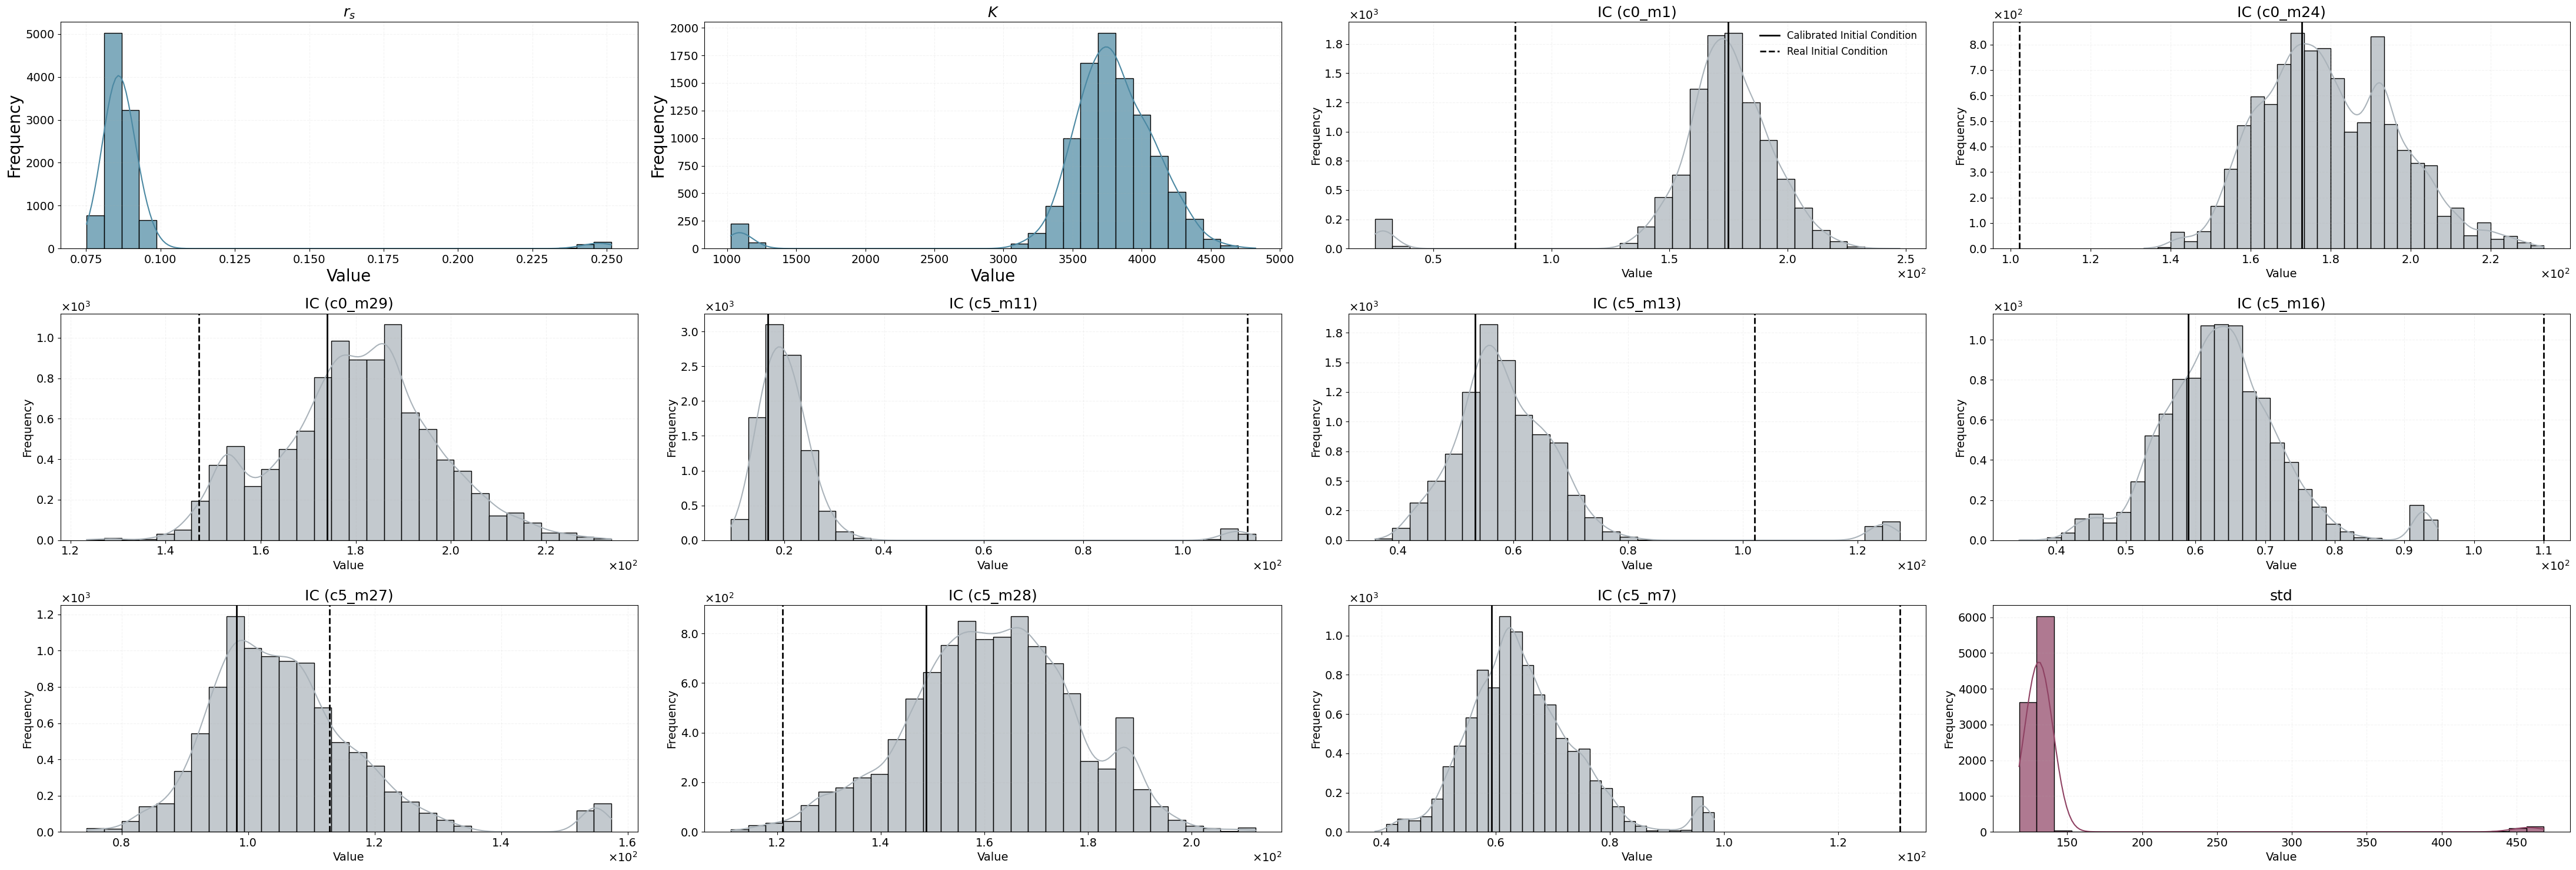

Processando distribuições para o grupo: control_resistant
Lendo o arquivo de chains: ./Output_Calibration/multi_chain_control_resistant_logV2.gz


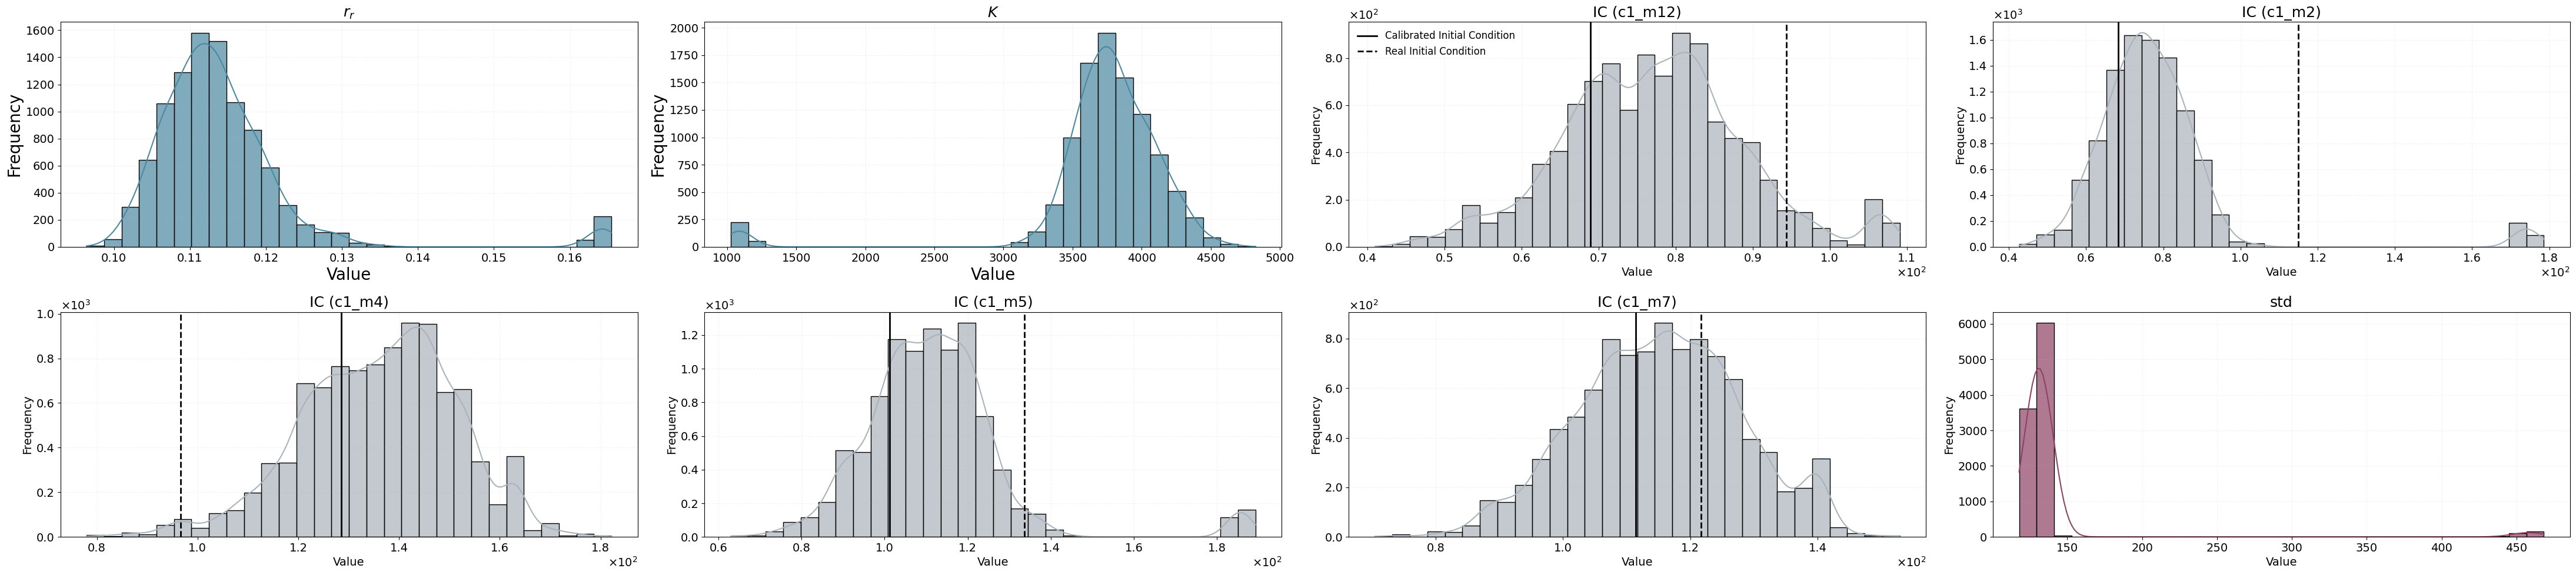

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker

import os
import pandas as pd
import glob
import math
import emcee
import string
import corner
import numpy as np
from tqdm import tqdm
from numba import jit
import concurrent.futures
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
from scipy.integrate import odeint
import pdse_project as pdse
import seaborn as sns
# import scipy.stats as stats
import sys
import random
import scipy.stats

class ScalarFormatterWithDecimals(mticker.ScalarFormatter):
    def _set_format(self):
        self.format = '%.1f'

# Find and sort all text files in the ./data directory
data_files = sorted(glob.glob("./data/*.txt"))

# Dictionary to store the parsed data, grouped by data type
full_data = {}

# Loop through each file in the data_files list
for file in data_files:
    # Extract the data type (treatment and cell type) from the file name
    data_type = os.path.basename(file).split('/')[-1].split('_c')[0]
    
    # Extract the mouse name (cohort identifier) from the file name
    mouse_name = 'c' + file.split('/')[-1].split('_c')[-1].split('_t')[0]
    
    # Extract the treatment days from the file name (as integers)
    t_days = np.array([int(t) for t in file.split('/')[-1].split('_c')[-1].split('.txt')[0].split('_t')[1:]])
    
    # Load the measurement data from the file (time, tumor volume)
    data = np.loadtxt(file)
    
    # Extract the specific treatment from the data type (e.g., radiation or control)
    treatment = os.path.basename(data_type).split('_')[0]
    
    # If this data type hasn't been seen before, create a new list in full_data
    if data_type not in full_data:
        full_data[data_type] = []
    
    # Append the mouse's data (including name, tumor measurements, treatment, and treatment days) to the appropriate group
    full_data[data_type].append({
        'name': mouse_name,
        'data': data,
        'treatment': treatment,
        'treatment_days': t_days
    })

def plot_distributions_by_group(chain_files, full_data, group_name, parameter_labels, fontsize='14', nCols=3, save = False, show = False, figure_name='distr_params', best_npz=None):
    """
    Plot the parameter distributions separately by group.

    Parameters:
    chain_files (list): List of files containing the chains.
    full_data (dict): Complete mouse data.
            group_name (str): Group name (e.g., ‘control_sensitive’, ‘control_resistant’).
            parameter_labels (list): List of parameter labels.
            fontsize (str): Font size.
            nCols (int): Number of columns in the subplot grid.
    figure_name (str): Base name for saving the graph (optional).
    """
    if not show and not save:
        return 
    
    print(f"Processing distributions for the group: {group_name}")
    all_samples = []

    colors = {
        'global_params': '#4B88A2',
        'initial_conditions': '#AAB3BA', 
        'std': '#8E4162' 
    }

    for chain_file in chain_files:
        print(f"Reading the chains file: {chain_file}")
        chain_data = np.loadtxt(chain_file)
        all_samples.append(chain_data)

    best_pars = None
    if best_npz is not None:
        npz = np.load(best_npz)

        best_pars = npz['pars']

    all_samples = np.vstack(all_samples)

    ndim = len(full_data[group_name]) 
    n_params = all_samples.shape[1] 

    global_params = range(n_params - (ndim + 1))
    initial_conditions = range(n_params - (ndim + 1), n_params - 1)
    std_index = n_params - 1 

    total_params = len(global_params) + ndim + 1
    nRows = int(np.ceil(total_params / nCols))

    fig, axes = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols * 11, nRows * 5), sharex=False)
    axes = axes.ravel()

    idx = 0 

    for param_idx in global_params:
        label = parameter_labels[param_idx]
        sns.histplot(all_samples[:, param_idx], bins=30, kde=True, ax=axes[idx], color=colors['global_params'], alpha=0.7)
        # if best_pars is not None:
        #     axes[idx].axvline(float(best_pars[param_idx]), linestyle='-', linewidth=2, color='black', label='Best Parameters')
        #     if idx == 0:
        #         axes[idx].legend(frameon=False, fontsize=12)
        axes[idx].set_title(f'{label}', fontsize=18)
        axes[idx].set_xlabel('Value', fontsize=20)
        axes[idx].set_ylabel('Frequency', fontsize=20)
        axes[idx].grid(True, linestyle='--', alpha=0.15)
        idx += 1

    for mouse_idx, param_idx in enumerate(initial_conditions):
        mouse_name = full_data[group_name][mouse_idx]['name']
        label = f'IC ({mouse_name})' 
        sns.histplot(all_samples[:, param_idx], bins=30, kde=True, ax=axes[idx], color=colors['initial_conditions'], alpha=0.7)
        v0 = float(full_data[group_name][mouse_idx]['data'][0, 1])
        if best_pars is not None:
            axes[idx].axvline(float(best_pars[param_idx]), linestyle='-', linewidth=2, color='black', label='Calibrated Initial Condition')

        axes[idx].axvline(v0, linestyle='--', linewidth=2, color='black', label='Real Initial Condition')

        if mouse_idx == 0:
            handles, labels = axes[idx].get_legend_handles_labels()
            by_label = dict(zip(labels, handles)) 
            axes[idx].legend(by_label.values(), by_label.keys(), frameon=False, fontsize=12)

        formatter = ScalarFormatterWithDecimals(useMathText=True)
        formatter.set_powerlimits((-3, 2))

        axes[idx].xaxis.set_major_formatter(formatter)
        axes[idx].yaxis.set_major_formatter(formatter)

        axes[idx].set_title(f'{label}', fontsize=18)
        axes[idx].set_xlabel('Value', fontsize=14)
        axes[idx].set_ylabel('Frequency', fontsize=14)
        axes[idx].grid(True, linestyle='--', alpha=0.15)
        idx += 1

    for empty_ax in axes[idx+1:]:
        empty_ax.remove() 

    sns.histplot(all_samples[:, std_index], bins=30, kde=True, ax=axes[idx], color=colors['std'], alpha=0.7)
    axes[idx].set_title('std', fontsize=18)
    axes[idx].set_xlabel('Value', fontsize=14)
    axes[idx].set_ylabel('Frequency', fontsize=14)
    axes[idx].grid(True, linestyle='--', alpha=0.15)

    plt.tight_layout()

    plt.tight_layout()
    if save:
        plt.savefig(f'{figure_name}_{group_name}.pdf', bbox_inches='tight', pad_inches=0.1)
    if show:
        plt.show()
    plt.close()

chain_files_sensitive = ['./Output_Calibration/multi_chain_control_sensitive_logV2.gz']
chain_files_resistant = ['./Output_Calibration/multi_chain_control_resistant_logV2.gz']

parameter_labels_sensitive = ['$r_s$', '$K$'] 
parameter_labels_resistant = ['$r_r$', '$K$'] 

plot_distributions_by_group(chain_files_sensitive, full_data, "control_sensitive", parameter_labels_sensitive, show = True, save = True, nCols=4, best_npz='./Output_Calibration/multi_ll_pars_control_sensitive_logV2.npz')

plot_distributions_by_group(chain_files_resistant, full_data, "control_resistant", parameter_labels_resistant, show = True, save = True, nCols=4, best_npz='./Output_Calibration/multi_ll_pars_control_resistant_logV2.npz')


Processando distribuições para o grupo: control_resistant
Lendo o arquivo de chains: ./Output_Calibration/multi_chain_control_resistant_logV2.gz


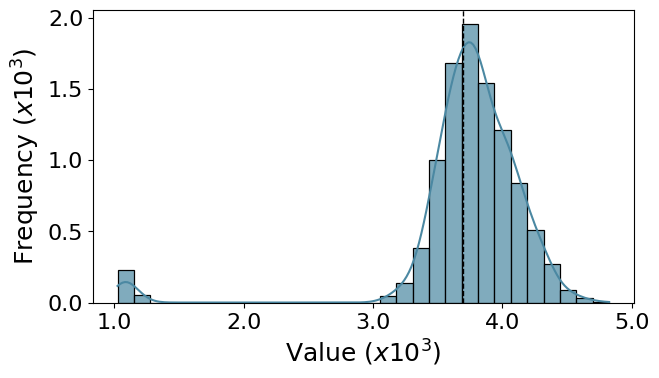

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker
class SciFormatterWithDecimals(mticker.ScalarFormatter):
    def _set_format(self):
        self.format = '%.1f'

def plot_distributions_by_group(chain_files, full_data, group_name, parameter_labels, 
                                fontsize='14', nCols=3, save = False, show = False, figure_name='distr_K', best_npz=None):
    """
    Plot the parameter distributions separately by group.

    Parameters:
    chain_files (list): List of files containing the chains.
    full_data (dict): Complete mouse data.
            group_name (str): Group name (e.g., ‘control_sensitive’, ‘control_resistant’).
            parameter_labels (list): List of parameter labels.
            fontsize (str): Font size.
            nCols (int): Number of columns in the subplot grid.
    figure_name (str): Base name for saving the graph (optional).
    """
    if not show and not save:
        return 
    
    formatter = pdse.configure_plot_settings(fontsize)
    plt.rcParams['font.size'] = fontsize
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3, 2))
    
    print(f"Processing distributions for the group: {group_name}")
    all_samples = []

    colors = {
        'global_params': '#4B88A2', 
        'initial_conditions': '#AAB3BA', 
        'std': '#8E4162' 
    }


    for chain_file in chain_files:
        print(f"Reading the chains file: {chain_file}")
        chain_data = np.loadtxt(chain_file)
        all_samples.append(chain_data)

    best_pars = None
    if best_npz is not None:
        npz = np.load(best_npz)
        best_pars = npz['pars']

    all_samples = np.vstack(all_samples)

    ndim = len(full_data[group_name])
    n_params = all_samples.shape[1]  

    # Separate indexes for global parameters, initial conditions, and std
    # to keep only the first global parameter
    first_global = 1 
    global_params = [first_global] 
    
    initial_conditions = range(n_params - (ndim + 1), n_params - 1) 
    std_index = n_params - 1 

    total_params = len(global_params)
    nRows = int(np.ceil(total_params / nCols))

    fig, axes = plt.subplots(nrows=nRows, ncols=nCols,
                             figsize=(nCols * 6, nRows * 4),
                             sharex=False)
    axes = axes.ravel()

    for i, param_idx in enumerate(global_params):
        ax = axes[i]
        label = parameter_labels[param_idx]
        sns.histplot(all_samples[:, param_idx],
                     bins=30, kde=True,
                     ax=ax, color=colors['global_params'], alpha=0.7)
        if best_pars is not None:
            axes[i].axvline(float(best_pars[param_idx]), linestyle='--', linewidth=1, color='black', label='Best Parameters')
            print(f"Best parameter for {label}: {best_pars[param_idx]} ± {np.std(all_samples[:, param_idx])}")

        ax.set_xlabel(r'Value ($x10^3$)', fontsize=18)
   

        sci_fmt = SciFormatterWithDecimals(useMathText=True)
        sci_fmt.set_scientific(True)      
        sci_fmt.set_powerlimits((0, 0)) 
        sci_fmt.set_useOffset(False)   

        ax.xaxis.set_major_formatter(sci_fmt)
        ax.yaxis.set_major_formatter(sci_fmt)
        ax.yaxis.offsetText.set_visible(False)
        ax.xaxis.offsetText.set_visible(False)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_ylabel(r'Frequency ($x10^3$)', fontsize=18)

        ax.grid(False)

    for empty_ax in axes[1:]:
         empty_ax.remove()

    plt.tight_layout()
    if save:
        plt.savefig(f'{figure_name}_{group_name}.png', dpi=300, bbox_inches='tight')
    if show:
        plt.show()
    plt.close()

chain_files_sensitive = ['./Output_Calibration/multi_chain_control_sensitive_logV2.gz']
chain_files_resistant = ['./Output_Calibration/multi_chain_control_resistant_logV2.gz']

parameter_labels_sensitive = ['$r_s$', '$K$'] 
parameter_labels_resistant = ['$r_r$', '$K$'] 

plot_distributions_by_group(chain_files_resistant, full_data, "control_resistant", parameter_labels_sensitive, save = True, show= True, nCols=4, best_npz='./Output_Calibration/multi_ll_pars_control_resistant_logV2.npz')


In [ ]:
import numpy as np
from scipy.stats import mannwhitneyu

def compare_posterior_param_between_groups(
    chain_files_sensitive,
    chain_files_resistant,
    param_col=0,
    param_name=r"r",
    seed=42,
    n_subsample=5000,
    two_sided=True,
    positive_only=True,
):
    """
    Compare posterior distributions of a parameter (e.g., beta) between two groups using MCMC samples from chain files.

    Return Bayesian metrics (posterior probability, ratio/difference, and CIs) and, optionally, p-value (Mann–Whitney U) at the reviewer's request.

        Args:
            chain_files_sensitive (list[str]): list of paths to the chains of the sensitive group.
            chain_files_resistant (list[str]): list of paths to the chains of the resistant group.
            param_col (int): index of the parameter column in the chain (in your case, beta ~ column 1).
            param_name (str): name of the parameter to print.
            seed (int): RNG seed.
            n_subsample (int): subsample size per group (mitigates autocorrelation/huge N).
            two_sided (bool): True -> two-tailed test; False -> one-tailed (robust > sensitive).
    positive_only (bool): filters out non-positive samples (useful for ratios).

    Returns:
    dict with summaries and p-value.
    """

    def _load_concat(chain_files):
        all_samples = []
        for cf in chain_files:
            x = np.loadtxt(cf)
            if x.ndim == 1:
                x = x.reshape(1, -1)
            all_samples.append(x)
        return np.vstack(all_samples)

    cs = _load_concat(chain_files_sensitive)
    cr = _load_concat(chain_files_resistant)

    beta_s = cs[:, param_col].astype(float)
    beta_r = cr[:, param_col].astype(float)

    if positive_only:
        beta_s = beta_s[beta_s > 0]
        beta_r = beta_r[beta_r > 0]

    if beta_s.size < 10 or beta_r.size < 10:
        raise ValueError("Few valid samples after filtering. Check ‘param_col’ and/or the positive_only filter.")

    rng = np.random.default_rng(seed)
    n_s = min(n_subsample, beta_s.size)
    n_r = min(n_subsample, beta_r.size)
    beta_s_sub = beta_s[rng.choice(beta_s.size, size=n_s, replace=False)]
    beta_r_sub = beta_r[rng.choice(beta_r.size, size=n_r, replace=False)]

    prob_gt = float(np.mean(beta_r_sub > beta_s_sub))

    ratio = beta_r_sub / beta_s_sub
    diff  = beta_r_sub - beta_s_sub

    ratio_med = float(np.median(ratio))
    ratio_ci  = tuple(np.percentile(ratio, [2.5, 97.5]).astype(float))

    diff_med = float(np.median(diff))
    diff_ci  = tuple(np.percentile(diff, [2.5, 97.5]).astype(float))

    alternative = "two-sided" if two_sided else "greater" 
    u_stat, pval = mannwhitneyu(beta_r_sub, beta_s_sub, alternative=alternative)

    out = {
        "param": param_name,
        "param_col": int(param_col),
        "n_used_sensitive": int(n_s),
        "n_used_resistant": int(n_r),
        "P(resistant > sensitive)": prob_gt,
        "median_ratio_res_over_sens": ratio_med,
        "ratio_95CI": ratio_ci,
        "median_diff_res_minus_sens": diff_med,
        "diff_95CI": diff_ci,
        "mannwhitney_U": float(u_stat),
        "mannwhitney_pvalue": float(pval),
        "mannwhitney_alternative": alternative,
    }

    print(f"\n[POSTERIOR COMPARISON] {param_name} (col={param_col})")
    print(f"Subsample sizes: sensitive={n_s}, resistant={n_r}")
    print(f"P({param_name}_r > {param_name}_s) = {out['P(resistant > sensitive)']:.6f}")
    print(f"Median ratio ({param_name}_r/{param_name}_s) = {ratio_med:.4g}  |  95% CI = [{ratio_ci[0]:.4g}, {ratio_ci[1]:.4g}]")
    print(f"Median diff  ({param_name}_r-{param_name}_s) = {diff_med:.4g}  |  95% CI = [{diff_ci[0]:.4g}, {diff_ci[1]:.4g}]")
    print(f"Mann–Whitney U ({alternative}) p-value = {pval:.3e}")

    return out

res_beta = compare_posterior_param_between_groups(
    chain_files_sensitive=['./Output_Calibration/multi_chain_control_sensitive_logV2.gz'],
    chain_files_resistant=['./Output_Calibration/multi_chain_control_resistant_logV2.gz'],
    param_col=0,   
    param_name=r"r",
    n_subsample=5000,
    two_sided=True     
)


[POSTERIOR COMPARISON] r (col=0)
Subsample sizes: sensitive=5000, resistant=5000
P(r_r > r_s) = 0.970000
Median ratio (r_r/r_s) = 1.306  |  95% CI = [0.4859, 1.778]
Median diff  (r_r-r_s) = 0.02634  |  95% CI = [-0.1256, 0.0723]
Mann–Whitney U (two-sided) p-value = 0.000e+00


# Box Plots

Arquivos salvos: boxplot_samples.csv, boxplot_best_params.csv
Construindo box-plots para os dois grupos, diferenciando parâmetros compartilhados.


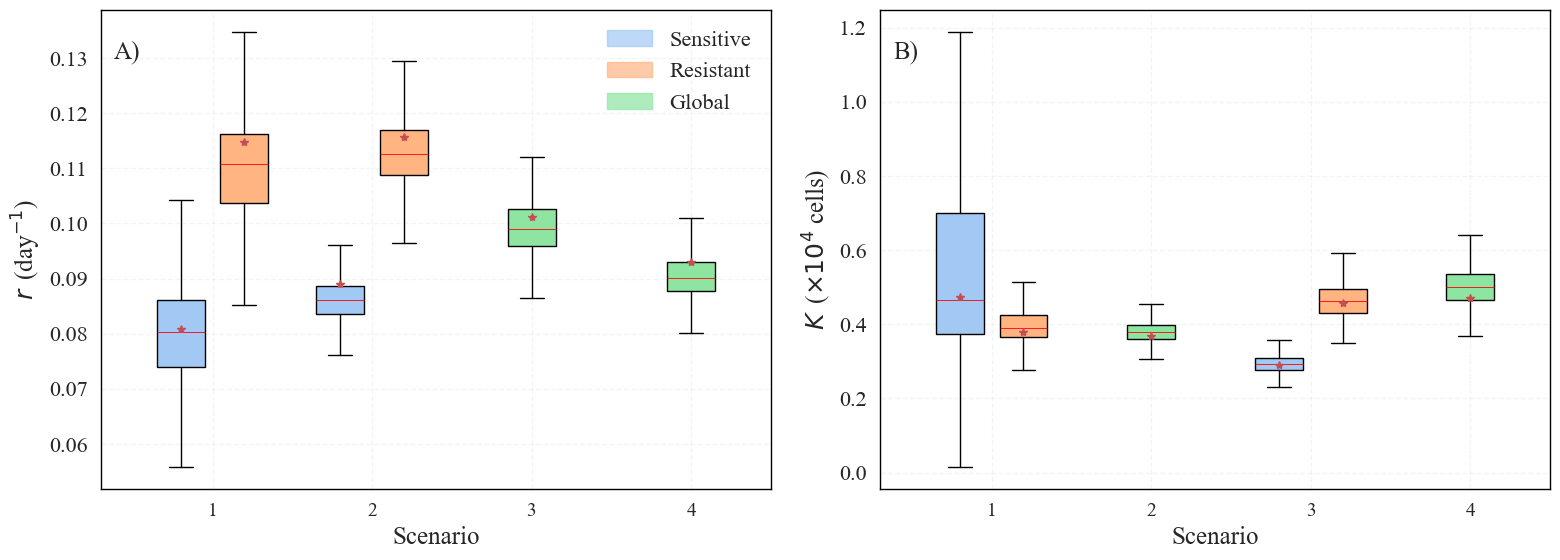

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import string
from matplotlib.ticker import FuncFormatter

def read_chains(chain_files):

    chains = []
    for cf in chain_files:
        chains.append(np.loadtxt(cf))
    return chains

def read_best_params(best_params_files):

    best_params = []
    for bf in best_params_files:
        npzfile = np.load(bf)
        best_params.append(npzfile['pars'])
    return best_params

chain_files_sensitive = [
    './Output_Calibration/multi_chain_control_sensitive_logV1.gz',
    './Output_Calibration/multi_chain_control_sensitive_logV2.gz',
    './Output_Calibration/multi_chain_control_sensitive_logV3.gz',
    './Output_Calibration/multi_chain_control_sensitive_logV4.gz'
]

best_params_files_sensitive = [
    './Output_Calibration/multi_ll_pars_control_sensitive_logV1.npz',
    './Output_Calibration/multi_ll_pars_control_sensitive_logV2.npz',
    './Output_Calibration/multi_ll_pars_control_sensitive_logV3.npz',
    './Output_Calibration/multi_ll_pars_control_sensitive_logV4.npz'
]

chain_files_resistant = [
    './Output_Calibration/multi_chain_control_resistant_logV1.gz',
    './Output_Calibration/multi_chain_control_resistant_logV2.gz',
    './Output_Calibration/multi_chain_control_resistant_logV3.gz',
    './Output_Calibration/multi_chain_control_resistant_logV4.gz'
]

best_params_files_resistant = [
    './Output_Calibration/multi_ll_pars_control_resistant_logV1.npz',
    './Output_Calibration/multi_ll_pars_control_resistant_logV2.npz',
    './Output_Calibration/multi_ll_pars_control_resistant_logV3.npz',
    './Output_Calibration/multi_ll_pars_control_resistant_logV4.npz'
]

chains_sens = read_chains(chain_files_sensitive)
best_sens = read_best_params(best_params_files_sensitive)
chains_res = read_chains(chain_files_resistant)
best_res = read_best_params(best_params_files_resistant)


def plot_boxplots_shared_or_not(chains_sens,
                                best_sens,
                                chains_res,
                                best_res,
                                parameter_labels,
                                shared_params_dict,
                                model_extension='_log',
                                nCols=2,
                                show=True,
                                save=False,
                                figure_name='boxplots_two_groups'):

    print("Building box plots for the two groups, differentiating shared parameters.")

    sns.set(style="whitegrid")

    colors = sns.color_palette("pastel")  
    medianprops = dict(color="red", linewidth=0.6)
    flierprops = dict(marker='o', color='orange', alpha=0.6, markersize=5)

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif']  = ['Times New Roman']
    plt.rcParams['font.size'] = 20
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.linewidth'] = 1.0

    n_params = len(parameter_labels)
    nRows = int(np.ceil(n_params / nCols))
    fig, axes = plt.subplots(nrows=nRows, ncols=nCols, figsize=(nCols * 8, nRows * 6), sharex=False)
    if n_params == 1:
        axes = [axes]
    else:
        axes = axes.ravel()

    y_labels = [
        r'$r\,$ (day$^{-1}$)',
        r'$K\,$ ($\times10^{4}$ cells)'
    ]

    

    for param_idx, label in enumerate(parameter_labels):
        ax = axes[param_idx]
        for scenario in range(1, 5):
            if label in shared_params_dict[scenario]:
                data_shared = chains_sens[scenario - 1][:, param_idx]
                box_shared = ax.boxplot([data_shared],
                                        positions=[scenario],
                                        widths=0.3,
                                        patch_artist=True,
                                        showfliers=False,
                                        medianprops=medianprops,
                                        flierprops=flierprops)
                box_shared['boxes'][0].set_facecolor(colors[2])  
                y_shared = best_sens[scenario - 1][param_idx]
                ax.plot(scenario, y_shared, 'r*', markersize=6, zorder=5)
            else:

                data_sens = chains_sens[scenario - 1][:, param_idx]
                data_res = chains_res[scenario - 1][:, param_idx]
                pos_sens = scenario - 0.2
                pos_res = scenario + 0.2
                box_sens = ax.boxplot([data_sens],
                                      positions=[pos_sens],
                                      widths=0.3,
                                      patch_artist=True,
                                      showfliers=False,
                                      medianprops=medianprops,
                                      flierprops=flierprops)
                for patch in box_sens['boxes']:
                    patch.set_facecolor(colors[0]) 
                box_res = ax.boxplot([data_res],
                                     positions=[pos_res],
                                     widths=0.3,
                                     patch_artist=True,
                                     showfliers=False,
                                     medianprops=medianprops,
                                     flierprops=flierprops)
                for patch in box_res['boxes']:
                    patch.set_facecolor(colors[1]) 
                y_sens = best_sens[scenario - 1][param_idx]
                y_res = best_res[scenario - 1][param_idx]
                ax.plot(pos_sens, y_sens, 'r*', markersize=6, zorder=5)
                ax.plot(pos_res, y_res, 'r*', markersize=6, zorder=5)

        ax.text(0.02, .9, f'{string.ascii_uppercase[param_idx]})', horizontalalignment='left', transform=ax.transAxes, fontsize=18)
        ax.set_xlabel("Scenario", fontsize=18)
        ax.set_ylabel(y_labels[param_idx], fontsize=18)
        ax.set_xticks(range(1, 5))
        ax.set_xticklabels(range(1, 5), fontsize=14)
        ax.tick_params(axis='y', which='major', labelsize=16)
        ax.grid(True, linestyle='--', alpha=0.2)        

        if param_idx == 1: 
            ax.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))
            ax.yaxis.get_offset_text().set_visible(False)

    sens_patch = mpatches.Patch(color=colors[0], alpha=0.7, label='Sensitive')
    res_patch = mpatches.Patch(color=colors[1], alpha=0.7, label='Resistant')
    sens_4_patch = mpatches.Patch(color=colors[2], alpha=0.7, label='Global')
    axes[0].legend(handles=[sens_patch, res_patch, sens_4_patch],
          loc=1, fontsize=16, frameon=False)

    for i in range(n_params, nRows * nCols):
        fig.delaxes(axes[i])

    plt.tight_layout()
    if save:
        plt.savefig(f'{figure_name}{model_extension}.png', dpi=300, bbox_inches='tight', pad_inches=0.02)
    if show:
        plt.show()
    else:
        plt.close()

parameter_labels = [r'$r$', r'$K$']

shared_params_dict = {
    1: [],   
    2: [r'$K$'],     
    3: [r'$r$'],    
    4: [r'$r$',r'$K$']  
}

def export_boxplot_data_to_csv(chains_sens,
                               best_sens,
                               chains_res,
                               best_res,
                               parameter_labels,
                               shared_params_dict,
                               samples_csv='boxplot_samples.csv',
                               best_csv='boxplot_best_params.csv'):

    rows_samples = []
    rows_best = []

    n_scenarios = len(chains_sens)
    n_params = len(parameter_labels)

    for scenario in range(1, n_scenarios + 1):
        scen_key = scenario 
        for param_idx in range(n_params):
            param_label = parameter_labels[param_idx]

            is_shared = param_label in shared_params_dict[scen_key]

            if is_shared:

                data_shared = chains_sens[scenario - 1][:, param_idx]
                for v in data_shared:
                    rows_samples.append({
                        "scenario": scenario,
                        "group": "Global",
                        "param_label": param_label,
                        "value": v
                    })

                y_shared = best_sens[scenario - 1][param_idx]
                rows_best.append({
                    "scenario": scenario,
                    "group": "Global",
                    "param_label": param_label,
                    "best_value": y_shared
                })
            else:

                data_sens = chains_sens[scenario - 1][:, param_idx]
                data_res  = chains_res[scenario - 1][:, param_idx]

                for v in data_sens:
                    rows_samples.append({
                        "scenario": scenario,
                        "group": "Sensitive",
                        "param_label": param_label,
                        "value": v
                    })
                for v in data_res:
                    rows_samples.append({
                        "scenario": scenario,
                        "group": "Resistant",
                        "param_label": param_label,
                        "value": v
                    })

                y_sens = best_sens[scenario - 1][param_idx]
                y_res  = best_res[scenario - 1][param_idx]

                rows_best.append({
                    "scenario": scenario,
                    "group": "Sensitive",
                    "param_label": param_label,
                    "best_value": y_sens
                })
                rows_best.append({
                    "scenario": scenario,
                    "group": "Resistant",
                    "param_label": param_label,
                    "best_value": y_res
                })

    df_samples = pd.DataFrame(rows_samples)
    df_best = pd.DataFrame(rows_best)

    df_samples.to_csv(samples_csv, index=False)
    df_best.to_csv(best_csv, index=False)

    print(f"Saved files: {samples_csv}, {best_csv}")

export_boxplot_data_to_csv(
    chains_sens, best_sens,
    chains_res, best_res,
    parameter_labels,
    shared_params_dict,
    samples_csv='boxplot_samples.csv',
    best_csv='boxplot_best_params.csv'
)

plot_boxplots_shared_or_not(chains_sens, best_sens,
                             chains_res, best_res,
                             parameter_labels,
                             shared_params_dict,
                             model_extension='_log',
                             nCols=2,
                             show=True,
                             save=True,
                             figure_name='fig4')

# Solutions with posterior CCC, PCC, trajectories, and credibility interval


Processando grupo: control_sensitive
Lendo o arquivo de chains: ./Output_Calibration/multi_chain_control_sensitive_logV2.gz

Processando grupo: control_resistant
Lendo o arquivo de chains: ./Output_Calibration/multi_chain_control_resistant_logV2.gz

./Output_Calibration/multi_ll_pars_control_sensitive_logV2.npz - Best Parameters: [8.89429860e-02 3.69671552e+03 1.74715487e+02 1.72673931e+02
 1.73966946e+02 1.66202131e+01 5.33788053e+01 5.89327440e+01
 9.81786082e+01 1.48759082e+02 5.92797761e+01 1.28030864e+02]

./Output_Calibration/multi_ll_pars_control_resistant_logV2.npz - Best Parameters: [1.15631515e-01 3.69671552e+03 6.89643720e+01 6.83394906e+01
 1.28497759e+02 1.01206668e+02 1.11420968e+02 1.28030864e+02]
{'control_sensitive': ({'name': 'c5_m11', 'data': array([[  0.        , 112.9144    ],
       [  1.        , 133.92361667],
       [  2.        , 153.47535   ],
       [  3.        , 167.98529   ],
       [  4.        , 187.2696    ],
       [  5.        , 153.82336667],
     

C:\Users\guilh\AppData\Local\Temp\ipykernel_25340\1734917580.py:736: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()                  # Ajuste automático de espaçamentos


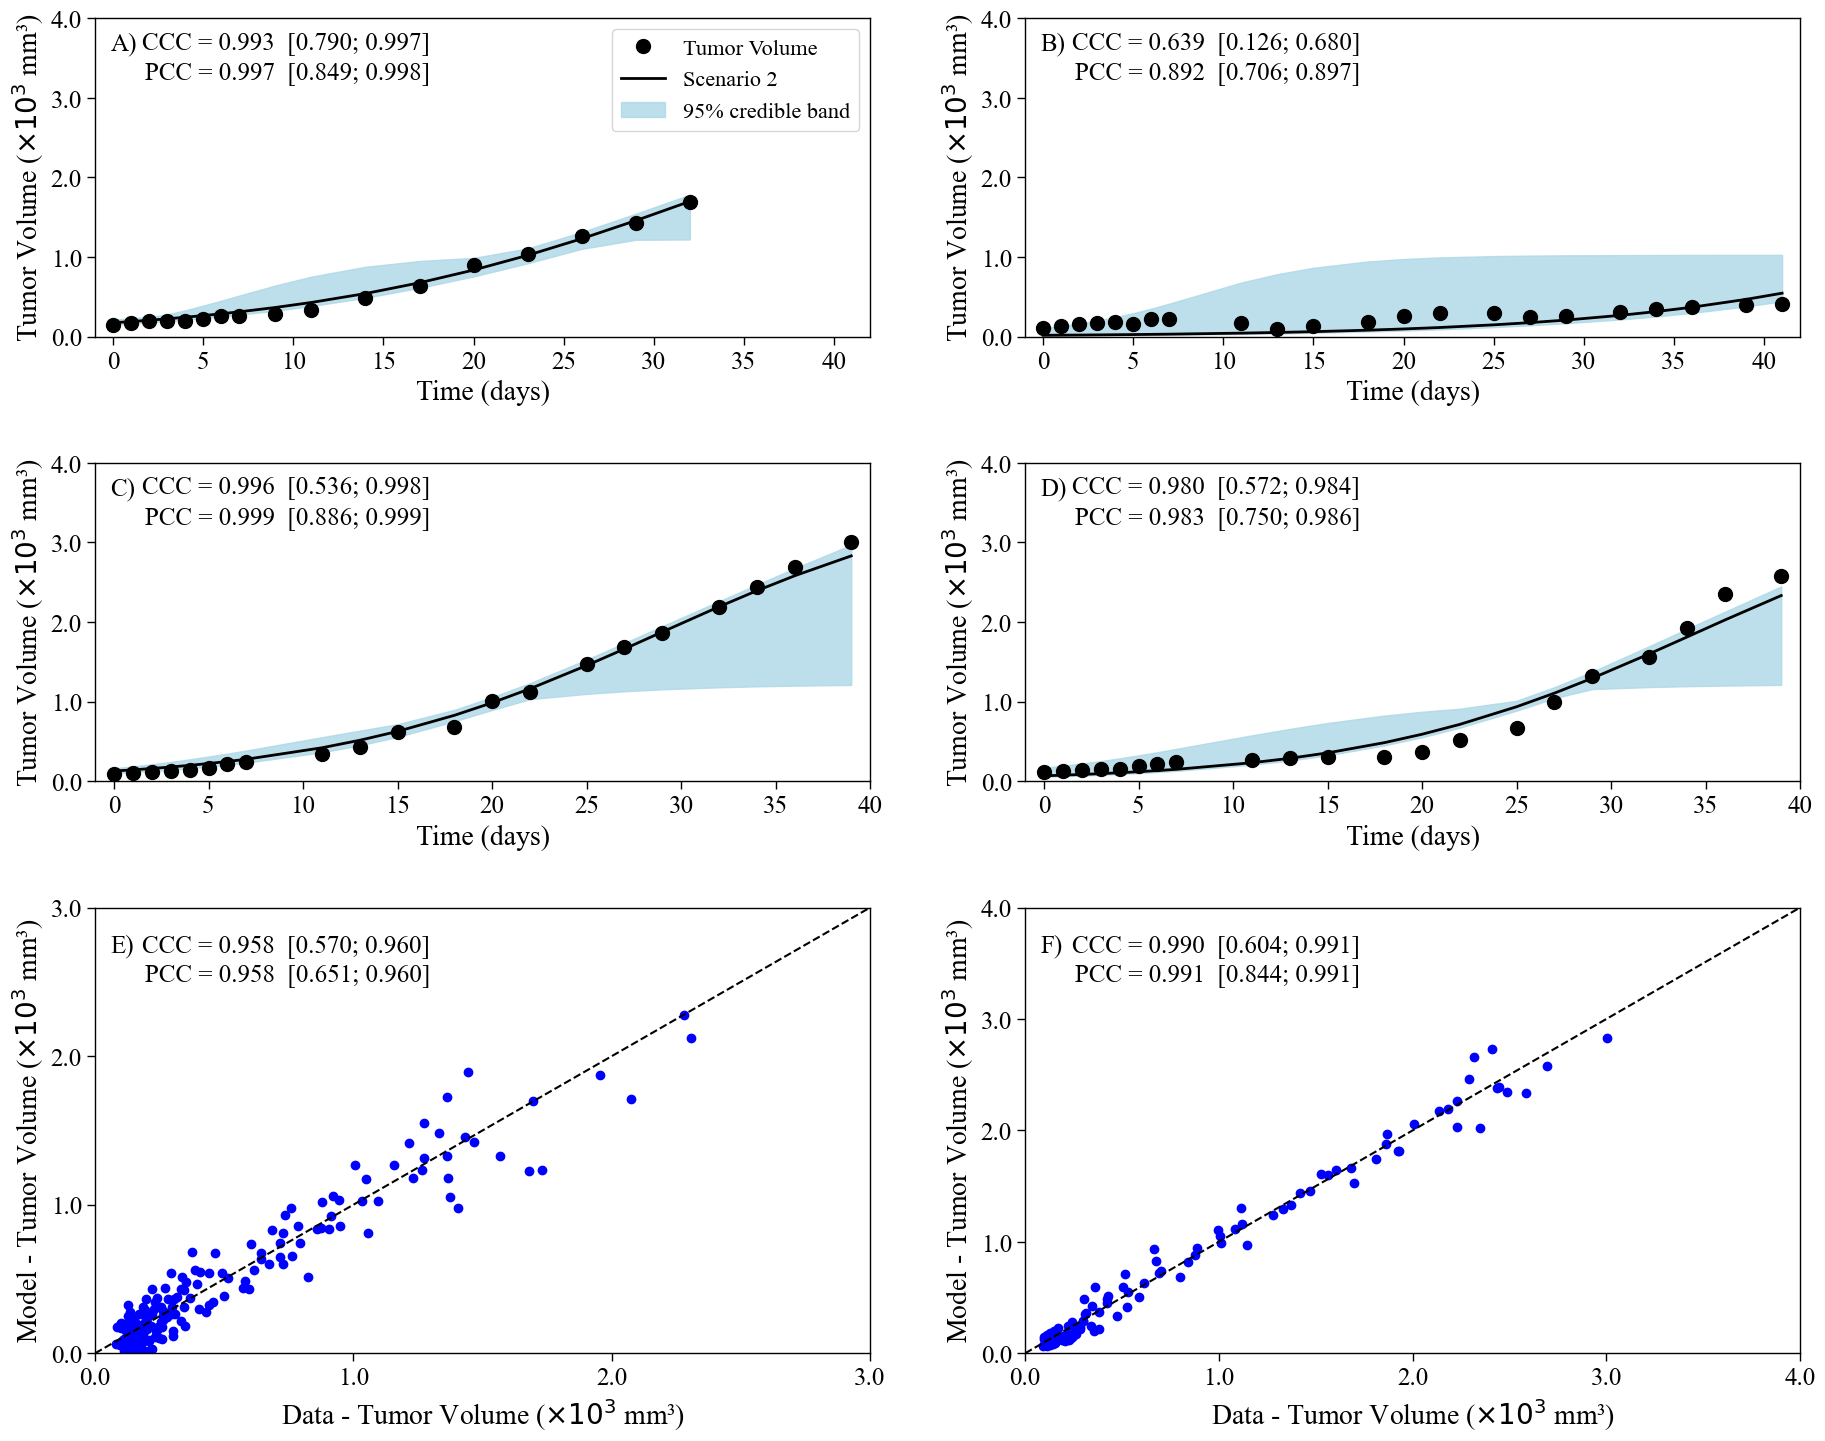

In [ ]:
import matplotlib.gridspec as gridspec 
import matplotlib.lines as mlines
import scipy.stats as stats
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
class ScalarFormatterWithDecimals(ScalarFormatter):
    def _set_format(self):
        self.format = '%.1f'

import os
import pandas as pd
import glob
import math
import emcee
import string
import corner
import numpy as np
from tqdm import tqdm
from numba import jit
import concurrent.futures
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
from scipy.integrate import odeint
import pdse_project as pdse
import seaborn as sns
# import scipy.stats as stats
import sys
import random
import scipy.stats




# Find and sort all text files in the ./data directory
data_files = sorted(glob.glob("./data/*.txt"))

# Dictionary to store the parsed data, grouped by data type
full_data = {}

# Loop through each file in the data_files list
for file in data_files:
    # Extract the data type (treatment and cell type) from the file name
    data_type = os.path.basename(file).split('/')[-1].split('_c')[0]
    
    # Extract the mouse name (cohort identifier) from the file name
    mouse_name = 'c' + file.split('/')[-1].split('_c')[-1].split('_t')[0]
    
    # Extract the treatment days from the file name (as integers)
    t_days = np.array([int(t) for t in file.split('/')[-1].split('_c')[-1].split('.txt')[0].split('_t')[1:]])
    
    # Load the measurement data from the file (time, tumor volume)
    data = np.loadtxt(file)
    
    # Extract the specific treatment from the data type (e.g., radiation or control)
    treatment = os.path.basename(data_type).split('_')[0]
    
    # If this data type hasn't been seen before, create a new list in full_data
    if data_type not in full_data:
        full_data[data_type] = []
    
    # Append the mouse's data (including name, tumor measurements, treatment, and treatment days) to the appropriate group
    full_data[data_type].append({
        'name': mouse_name,
        'data': data,
        'treatment': treatment,
        'treatment_days': t_days
    })


def ccc(x, y):
    x, y = np.asarray(x), np.asarray(y)
    sxy = np.sum((x - x.mean()) * (y - y.mean())) / x.size
    return 2*sxy / (np.var(x) + np.var(y) + (x.mean()-y.mean())**2)

def pcc(x, y):
    x, y = np.asarray(x), np.asarray(y)
    sxy = np.sum((x - x.mean()) * (y - y.mean())) / x.size
    return sxy / (np.std(x) * np.std(y))

def summarize_posterior(arr, alpha=0.05):
    arr = np.asarray(arr, dtype=float)
    med = np.median(arr)
    lo, hi = np.percentile(arr, [100*alpha/2, 100*(1-alpha/2)])
    return med, lo, hi


@jit(nopython=True)
def model_log(y, t, growth_rate, carrying_capacity):
    tumor = y
    tumorVolume = growth_rate * tumor * (1 - tumor/carrying_capacity)
    return tumorVolume


def solve_model(model_extension, time_array, parameters, initial_condition, type_sol = 'data'):
    model_name = 'model' + model_extension
    model_func = globals()[model_name]  # Get the function object by its name

    if type_sol == 'smooth':
        bgn_p = round(time_array[0],1)
        end_p = round(time_array[-1],1)
        time_array = np.linspace(bgn_p,end_p, int((end_p-bgn_p)/0.1)+1)
        sol = odeint(model_func, t = time_array, y0 = [initial_condition], args = parameters, mxstep=2000)
        return np.column_stack((time_array, sol))
    else:
        return odeint(model_func, t = time_array, y0 = [initial_condition], args = parameters, mxstep=2000)
    
def find_max_time_per_group(full_data):
    max_times = {}

    for group, mice_data in full_data.items():
        max_time = 0
 
        for mouse in mice_data:
            time_data = mouse['data'][:, 0]  
            max_time_mouse = max(time_data) 

            if max_time_mouse > max_time:
                max_time = max_time_mouse

        max_times[group] = max_time

    return max_times

def analyze_chains_for_groups(chain_files_sensitive, chain_files_resistant, full_data, seed=42):
    """
    Function to analyze the chains of two groups (control_sensitive and control_resistant), solve the model for 50 randomly selected samples, and store the results.
Parameters:

    Parameters:
        chain_files_sensitive (list): List of chain files for the ‘control_sensitive’ group.
        chain_files_resistant (list): List of chain files for the ‘control_resistant’ group.
        full_data (dict): Complete data grouped by type.

    Returns:
        dict: Dictionary containing arrays of model solutions for each group.
    """
    results = {}

    for group, chain_files in zip(['control_sensitive', 'control_resistant'], 
                                  [chain_files_sensitive, chain_files_resistant]):
        print(f"\nProcessing group: {group}")
        
        group_results = {} 

        model_extension = "_log"

        ndim = len(full_data[group])
        
        for chain_file in chain_files:
            print(f"Reading the chains file: {chain_file}")

            chain_data = np.loadtxt(chain_file)

            random.seed(seed)
            selected_indices = random.sample(range(len(chain_data)), 1000)
            selected_samples = chain_data[selected_indices, :]

            for idx, mouse_data in enumerate(full_data[group]):
                mouse_name = mouse_data['name']
                data = mouse_data['data']

                num_time_points = len(data[:, 0])
                solution_matrix = np.zeros((len(selected_samples), num_time_points))

                for sample_idx, theta in enumerate(selected_samples):
                    parameters = tuple(theta[:-(ndim+1)]) 
                    initial_condition = theta[-(ndim+1) + idx]
                  
                    solution = solve_model(model_extension, data[:, 0], parameters, initial_condition, "data")
                    matched_solution_volumes = solution[:, 0]

                    solution_matrix[sample_idx, :] = matched_solution_volumes

                group_results[mouse_name] = solution_matrix

        results[group] = group_results

    return results

chain_files_sensitive = [
    './Output_Calibration/multi_chain_control_sensitive_logV2.gz',
]

chain_files_resistant = [
    './Output_Calibration/multi_chain_control_resistant_logV2.gz'
]

results = analyze_chains_for_groups(chain_files_sensitive, chain_files_resistant, full_data)


def summarize_solutions_with_ci(results):
    """
    Bayesian prediction band: 2.5–97.5 percentiles of trajectories.
    """
    summarized = {}
    for grp, mice in results.items():
        summarized[grp] = {}
        for mouse, mtx in mice.items():  
            mean = mtx.mean(axis=0)
            p_lo, p_hi = np.percentile(mtx, [2.5, 97.5], axis=0)
            summarized[grp][mouse] = {
                'mean': mean,
                'ci_positive': p_hi,
                'ci_negative': p_lo
            }
    return summarized

summarized_results1 = summarize_solutions_with_ci(results)

def configure_plot_settings(fontsize):
    plt.rcParams['font.size'] = fontsize
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3, 2))
    return formatter


def finalize_plot(fig, axes, nScenarios, nCols, nRows, full_exp, full_model, save, show, figure_name, formatter):
    final_exp = np.concatenate(full_exp, axis=0) if full_exp else np.array([])
    final_model = np.concatenate(full_model, axis=0) if full_model else np.array([])

    if final_exp.size == 0 or final_model.size == 0:
        print("Error: One of the final arrays is empty.")
        return

    rounded_max = math.ceil(np.max(np.concatenate([final_exp, final_model])) / 1000) * 1000
    for ax in axes[:nScenarios]:
        ax.set_ylim((0, rounded_max))
        ax.yaxis.set_major_formatter(formatter)
    for i in range(nScenarios, nRows * nCols):
        fig.delaxes(axes[i])
    if save:

        plt.savefig(figure_name + '.png', dpi=300, bbox_inches='tight', pad_inches=0.02)
    if show:
        plt.show()
    else:
        plt.close()

def posterior_corr_from_chain(chain_path, model_extension, full_data, group,
                                n_samp=1000, seed=42):
    if not os.path.exists(chain_path):
        print(f"[ERRO] Chain não encontrada: {chain_path}")
        return None
    chain = np.loadtxt(chain_path)
    if chain.ndim == 1:
        chain = chain.reshape(1, -1)
    ndim = len(full_data[group])
    n_samp = min(n_samp, chain.shape[0])
    rng = np.random.default_rng(seed)
    idx = rng.choice(chain.shape[0], size=n_samp, replace=False)
    thetas = chain[idx, :]

    ccc_samples, pcc_samples = [], []
    for theta in thetas:
        params = tuple(theta[:-(ndim+1)])
        ics = theta[-(ndim+1):-1]
        full_model, full_exp = [], []
        for i, mouse in enumerate(full_data[group]):
            t = mouse['data'][:, 0]; y = mouse['data'][:, 1]
            sol = solve_model(model_extension, t, params, ics[i], 'data')
            if sol.ndim == 2 and sol.shape[1] == 1:
                sol = sol[:, 0]
            full_model.append(sol); full_exp.append(y)
        model_concat = np.concatenate(full_model)
        exp_concat = np.concatenate(full_exp)
        ccc_samples.append(float(np.clip(ccc(model_concat, exp_concat), -1, 1)))
        pcc_samples.append(float(np.clip(pcc(model_concat, exp_concat), -1, 1)))

    ccc_med, ccc_lo, ccc_hi = summarize_posterior(ccc_samples)
    pcc_med, pcc_lo, pcc_hi = summarize_posterior(pcc_samples)
    return {"ccc_summary": (ccc_med, ccc_lo, ccc_hi),
            "pcc_summary": (pcc_med, pcc_lo, pcc_hi)}

res_cs = posterior_corr_from_chain(
    './Output_Calibration/multi_chain_control_sensitive_logV2.gz',
    '_log', full_data, 'control_sensitive', n_samp=1000, seed=42)

res_cr = posterior_corr_from_chain(
    './Output_Calibration/multi_chain_control_resistant_logV2.gz',
    '_log', full_data, 'control_resistant', n_samp=1000, seed=42)

ccc_med_cs, ccc_lo_cs, ccc_hi_cs = res_cs["ccc_summary"]
pcc_med_cs, pcc_lo_cs, pcc_hi_cs = res_cs["pcc_summary"]
ccc_med_cr, ccc_lo_cr, ccc_hi_cr = res_cr["ccc_summary"]
pcc_med_cr, pcc_lo_cr, pcc_hi_cr = res_cr["pcc_summary"]


def posterior_corr_per_mouse(chain_path, model_extension, full_data, group,
                             n_samp=1000, seed=42):

    if not os.path.exists(chain_path):
        print(f"[ERRO] Chain não encontrada: {chain_path}")
        return None, None

    chain = np.loadtxt(chain_path)
    if chain.ndim == 1:
        chain = chain.reshape(1, -1)

    ndim = len(full_data[group])
    n_samp = min(n_samp, chain.shape[0])

    rng = np.random.default_rng(seed)
    idx = rng.choice(chain.shape[0], size=n_samp, replace=False)
    thetas = chain[idx, :]

    mouse_names = [m['name'] for m in full_data[group]]
    ccc_samples = {name: [] for name in mouse_names}
    pcc_samples = {name: [] for name in mouse_names}

    for theta in thetas:
        params = tuple(theta[:-(ndim+1)])
        ics    = theta[-(ndim+1):-1]

        for i, mouse in enumerate(full_data[group]):
            name = mouse['name']
            t = mouse['data'][:, 0]
            y = mouse['data'][:, 1]

            sol = solve_model(model_extension, t, params, ics[i], 'data')
            if sol.ndim == 2 and sol.shape[1] == 1:
                sol = sol[:, 0]

            ccc_val = float(np.clip(ccc(sol, y), -1, 1))
            pcc_val = float(np.clip(pcc(sol, y), -1, 1))

            ccc_samples[name].append(ccc_val)
            pcc_samples[name].append(pcc_val)

    ccc_res = {name: summarize_posterior(vals) for name, vals in ccc_samples.items()}
    pcc_res = {name: summarize_posterior(vals) for name, vals in pcc_samples.items()}

    return ccc_res, pcc_res

ccc_cs, pcc_cs = posterior_corr_per_mouse(
    './Output_Calibration/multi_chain_control_sensitive_logV2.gz',
    '_log', full_data, 'control_sensitive', n_samp=1000, seed=42)

ccc_cr, pcc_cr = posterior_corr_per_mouse(
    './Output_Calibration/multi_chain_control_resistant_logV2.gz',
    '_log', full_data, 'control_resistant', n_samp=1000, seed=42)

post_corr = {
    **{f"s_{name}": ccc_cs[name] for name in ccc_cs.keys()},
    **{f"r_{name}": ccc_cr[name] for name in ccc_cr.keys()}
}
post_pcc = {
    **{f"s_{name}": pcc_cs[name] for name in pcc_cs.keys()},
    **{f"r_{name}": pcc_cr[name] for name in pcc_cr.keys()}
}
    
def plot_maxll_solution_with_deviation_melhor_pior_juntos(
    files_locations_sensitive, 
    files_locations_resistant, 
    summarized_results, 
    full_data, 
    show=True, 
    save=True, 
    fontsize='18', 
    figure_name='maxll_figure'):

    if not show and not save:
        return 

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif']  = ['Times New Roman']
    formatter = configure_plot_settings(fontsize)

    plt.rcParams['font.size'] = fontsize

    def get_suffix(file_location):
        return file_location.split('_')[-1].split('.')[0]

    manual_labels = {
        'logV1': "$r_s$, $r_r$, $K_s$, $K_r$",
        'logV2': "Scenario 2",
        'logV3': "$r$, $K_s$ and $K_r$",
        'logV4': "$r$ and $K$"
    }

    def load_parameters(files):
        all_theta, all_suffix = [], []
        for file_location in files:
            npzfile = np.load(file_location)
            best_pars = npzfile['pars']
            all_theta.append(best_pars)
            all_suffix.append(get_suffix(file_location))
            print(f"\n{file_location} - Best Parameters:", best_pars)
        return all_theta, all_suffix

    all_theta_sensitive, all_suffix_sensitive = load_parameters(files_locations_sensitive or [])
    all_theta_resistant, all_suffix_resistant = load_parameters(files_locations_resistant or [])

    max_times = find_max_time_per_group(full_data)
    linestyles = ['solid', 'dashed', 'dotted', 'dashdot']
    colors = ['black', 'red', 'green', 'blue', 'cyan']


    def get_best_worst_mice(group, theta_list, suffix_list):
        """
        Returns the mouse with the SMALLEST and LARGEST CCC-median from the posterior.
        The plotted solution remains the maximum a posteriori (MAP) solution.
        """
        mouse_metrics = []
        ndim = len(full_data[group])

        for idx, mouse_data in enumerate(full_data[group]):
            mouse_name, data = mouse_data['name'], mouse_data['data']

            key = f"{'s' if group == 'control_sensitive' else 'r'}_{mouse_name}"
            ccc_med, ccc_lo, ccc_hi = post_corr[key]
            pcc_med, pcc_lo, pcc_hi = post_pcc[key]

            params = tuple(theta_list[0][:-(ndim + 1)])
            ic = theta_list[0][-(ndim + 1) + idx]
            sol = solve_model("_log", data[:, 0], params, ic, "smooth")
            mask = np.isin(sol[:, 0], data[:, 0])
            sol_times, sol_volumes = sol[mask, 0], sol[mask, 1]

            mouse_metrics.append({
                'name': mouse_name,
                'data': data,
                'idx': idx,
                'best_or_worst': ccc_med, 
                'solution': (sol_times, sol_volumes, 0), 

                'ccc_med': ccc_med, 'ccc_lo': ccc_lo, 'ccc_hi': ccc_hi,
                'pcc_med': pcc_med, 'pcc_lo': pcc_lo, 'pcc_hi': pcc_hi
            })

        best_mouse = max(mouse_metrics, key=lambda m: m['best_or_worst'])
        worst_mouse = min(mouse_metrics, key=lambda m: m['best_or_worst'])

        return worst_mouse, best_mouse    

    group_results_info = {
        'control_sensitive': get_best_worst_mice('control_sensitive', all_theta_sensitive, all_suffix_sensitive),
        'control_resistant': get_best_worst_mice('control_resistant', all_theta_resistant, all_suffix_resistant)
    }

    # print(group_results_info)

    def get_final_data(group_name, theta):
        final_exp, final_model = [], []
        if group_name in full_data:
            ndim = len(full_data[group_name])
            for idx, mouse_data in enumerate(full_data[group_name]):
                data = mouse_data['data']
                parameters = tuple(theta[:-(ndim+1)])
                initial_condition = theta[-(ndim+1) + idx]
                solution = solve_model("_log", data[:, 0], parameters, initial_condition, "smooth")
                mask = np.isin(solution[:, 0], data[:, 0])
                sol_volumes = solution[mask, 1]
                final_exp.append(data[:, 1])
                final_model.append(sol_volumes)
        return final_exp, final_model

    final_exp_sensitive, final_model_sensitive = get_final_data('control_sensitive', all_theta_sensitive[0])
    final_exp_resistant, final_model_resistant = get_final_data('control_resistant', all_theta_resistant[0])

    def plot_scatter_ax(ax, final_exp, final_model, formatter,
                    ccc_val=None, ccc_ic=None, pcc_val=None, pcc_ic=None):
        all_cccs = []
        for i in range(len(final_exp)):
            ccc_value = pdse.ccc(final_model[i], final_exp[i])
            all_cccs.append(ccc_value)
            ax.plot(final_exp[i], final_model[i], 'o', color='blue')

        ax.set_xlabel(r'Data - Tumor Volume ($\times 10^3$ mm³)', fontsize=20)
        ax.set_ylabel(r'Model - Tumor Volume ($\times 10^3$ mm³)', fontsize=20)

        line = mlines.Line2D([0, 1], [0, 1], color='black', linestyle='dashed')
        line.set_transform(ax.transAxes)
        ax.add_line(line)

        final_exp = np.concatenate(final_exp)
        final_model = np.concatenate(final_model)
        max_value = math.ceil(max(max(final_exp), max(final_model)) / 1000) * 1000
        ticks = np.linspace(0, max_value, num=int(max_value/1000)+1)

        ax.set_xlim((0, max_value))
        ax.set_ylim((0, max_value))
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        
        formatter = ScalarFormatterWithDecimals(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 2))

        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-3, 2), useOffset=False)
        ax.grid(False)

        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1.0)

        ax.tick_params(axis='both', which='major', length=6, width=1, direction='out', color='black', bottom=True, left=True)
        ax.minorticks_off()

        pccT = pdse.pcc(final_model, final_exp)
        cccT = pdse.ccc(final_model, final_exp)
        mapeT = pdse.mape(final_model, final_exp)
        if ccc_val is not None and ccc_ic is not None and pcc_val is not None and pcc_ic is not None:
            # posterior medians + CI
            ax.text(0.06, 0.94,
                    f'CCC = {ccc_val:.3f}  [{ccc_ic[0]:.3f}; {ccc_ic[1]:.3f}]',
                    transform=ax.transAxes, fontsize=18, verticalalignment='top')
            ax.text(0.065, 0.875,
                f'PCC = {pcc_val:.3f}  [{pcc_ic[0]:.3f}; {pcc_ic[1]:.3f}]',
                transform=ax.transAxes, fontsize=18, verticalalignment='top')
        else:

            pccT = pdse.pcc(final_model, final_exp)
            cccT = pdse.ccc(final_model, final_exp)
            mapeT = pdse.mape(final_model, final_exp)
            ax.text(0.06, 0.82,
                    f'CCC/PCC/MAPE = {cccT:.2f}/{pccT:.2f}/{mapeT:.2f}%',
                    transform=ax.transAxes, fontsize=18)

    fig = plt.figure(figsize=(22, 15))
    gs = gridspec.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1.4])

    gs.update(hspace=0.35) 

    axes_ts = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]
    axes_scatter = [fig.add_subplot(gs[2, j]) for j in range(2)]

    full_exp, full_model = [], []

    for i, group in enumerate(['control_sensitive', 'control_resistant']):
        if group not in group_results_info:
            continue
        best_mouse, worst_mouse = group_results_info[group]
        max_time = max_times[group]
        suffix_list = all_suffix_sensitive if group == 'control_sensitive' else all_suffix_resistant

        for ax, mouse_info, tag in zip(axes_ts[i*2:i*2+2], [worst_mouse, best_mouse], ['Pior', 'Melhor']):
            mouse_name, data = mouse_info['name'], mouse_info['data']
            ax.plot(data[:, 0], data[:, 1], 'o', color='black', markersize=10, label='Tumor Volume')
            ax.set_xlabel('Time (days)', fontsize=20)
            ax.set_ylabel(r'Tumor Volume ($\times10^3$ mm³)', fontsize=20)
            ax.set_xlim((-1, max_time + 1))
            ax.ticklabel_format(axis='y', style='scientific', scilimits=(-3, 2), useOffset=False)
            ax.yaxis.get_offset_text().set_visible(False)

            formatter = ScalarFormatterWithDecimals(useMathText=True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-3, 2))
            ax.yaxis.set_major_formatter(formatter)
            ax.yaxis.get_major_formatter().set_scientific(False)     
            ax.yaxis.offsetText.set_visible(False)
            ax.grid(False)

            sol_times, sol_volumes, scenario_idx = mouse_info['solution']
            label = manual_labels.get(suffix_list[scenario_idx], f'Model {suffix_list[scenario_idx]}')
            ax.plot(sol_times, sol_volumes, color=colors[scenario_idx], linestyle=linestyles[scenario_idx], linewidth=2, label=label)

            ccc_med, ccc_lo, ccc_hi = mouse_info['ccc_med'], mouse_info['ccc_lo'], mouse_info['ccc_hi']
            pcc_med, pcc_lo, pcc_hi = mouse_info['pcc_med'], mouse_info['pcc_lo'], mouse_info['pcc_hi']

            ax.text(0.06, 0.96,
                    f'CCC = {ccc_med:.3f}  [{ccc_lo:.3f}; {ccc_hi:.3f}]',
                    transform=ax.transAxes,
                    fontsize=18,
                    verticalalignment='top')

            ax.text(0.065, 0.865,
                    f'PCC = {pcc_med:.3f}  [{pcc_lo:.3f}; {pcc_hi:.3f}]',
                    transform=ax.transAxes,
                    fontsize=18,
                    verticalalignment='top')

            if mouse_name in summarized_results[group]:
                res = summarized_results[group][mouse_name]
                ax.fill_between(data[:, 0],
                res['ci_positive'],
                res['ci_negative'],
                color='lightblue', alpha=0.8, label= r'95% credible band')
            if ax == axes_ts[0]:
                ax.legend(loc=1, fontsize=16)
            full_model.append(sol_volumes)
            full_exp.append(data[:, 1])

    for idx, ax in enumerate(axes_ts + axes_scatter):
        ax.text(0.02, 0.9, f'{string.ascii_uppercase[idx]})', transform=ax.transAxes, fontsize=18)
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.0)
        ax.tick_params(axis='both', which='major', length=6, width=1, direction='out', color='black', bottom=True, left=True)
        ax.minorticks_off()

        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-3, 2), useOffset=False)
        ax.yaxis.offsetText.set_visible(False)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        
        ax.ticklabel_format(axis='x', style='scientific', scilimits=(-3, 2), useOffset=False)
        ax.xaxis.get_offset_text().set_visible(False)

    plot_scatter_ax(axes_scatter[0], final_exp_sensitive, final_model_sensitive, formatter,
                ccc_val=ccc_med_cs, ccc_ic=[ccc_lo_cs, ccc_hi_cs],
                pcc_val=pcc_med_cs, pcc_ic=[pcc_lo_cs, pcc_hi_cs])

    plot_scatter_ax(axes_scatter[1], final_exp_resistant, final_model_resistant, formatter,
                ccc_val=ccc_med_cr, ccc_ic=[ccc_lo_cr, ccc_hi_cr],
                pcc_val=pcc_med_cr, pcc_ic=[pcc_lo_cr, pcc_hi_cr])

    fig.tight_layout()           
    fig.subplots_adjust(top=1)   
    
    finalize_plot(fig, axes_ts, 4, 2, 2, full_exp, full_model, save, show, figure_name, formatter)
    if save:
        fig.savefig(figure_name + '.png', dpi=300, bbox_inches='tight', pad_inches=0.02)
    plt.show()

    return

plot_maxll_solution_with_deviation_melhor_pior_juntos(
    files_locations_sensitive=[
        './Output_Calibration/multi_ll_pars_control_sensitive_logV2.npz'
    ],
    files_locations_resistant=[
        './Output_Calibration/multi_ll_pars_control_resistant_logV2.npz'
    ],
    summarized_results=summarized_results1, 
    full_data=full_data,                   
    show=True,
    save=True,
    figure_name='fig5_IC_bayesian' 
)



The next diagnostic was designed to assess whether the temporary narrowing of the pointwise 95% credible bands (the “pinch” observed near day $\sim 25$ in Panels A and D) is a robust posterior feature or a plotting/sampling artifact. For a given animal, we use the posterior trajectory matrix $Y^{(s)}(t_j)$ (one trajectory per posterior draw) to compute pointwise quantiles $q_{2.5}(t_j)$ and $q_{97.5}(t_j)$, and we plot both the trajectories and the band width $w(t_j)=q_{97.5}(t_j)-q_{2.5}(t_j)$ over time. To quantify whether the band behavior could be driven by trajectory crossings (i.e., posterior draws changing their relative ordering over time), we also compute Kendall’s $\tau$ and Spearman’s $\rho$ between the vector of posterior predictions at $t \approx 25$ days and at the final observation time; values close to 1 indicate that trajectories remain largely ordered (few crossings), whereas lower values indicate substantial reordering (many crossings/parameter trade-offs). In our results, Panel A exhibits high rank correlations ($\tau$ and $\rho$ close to 1), supporting the interpretation that the narrowing around day $\sim 25$ reflects a time window where the data most strongly constrain the posterior trajectories, while Panel D shows moderate rank correlations, indicating appreciable reordering that can further compress pointwise quantiles; in both cases, the subsequent widening at late times is consistent with propagation and amplification of parameter uncertainty during extrapolation.



[DIAGNÓSTICO] group=control_sensitive, mouse=c0_m29
t_focus ~ 26.00 (idx 14) | width(t_focus) = 211
min width em t = 0.00 (idx 0) | min width = 64.78
Kendall tau (t_focus vs t_end) = 0.831 (p=0)
Spearman rho (t_focus vs t_end) = 0.960 (p=0)
Interpretação: tau/rho próximos de 1 -> pouca reordenação (poucos cruzamentos); tau/rho baixos -> muita reordenação (muitos cruzamentos).


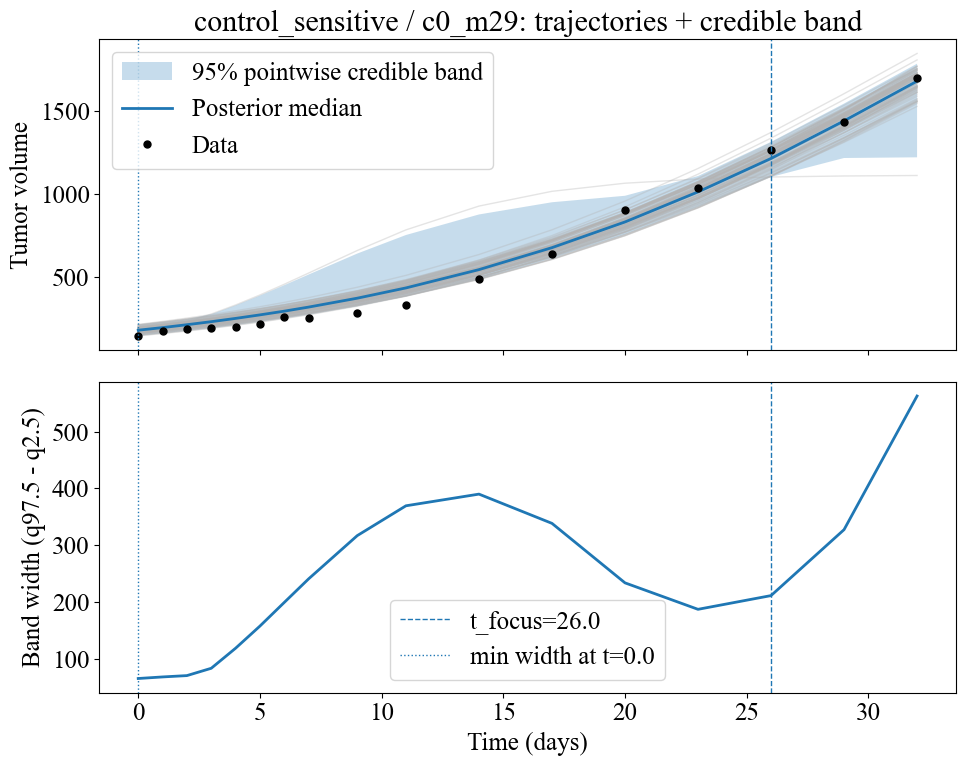

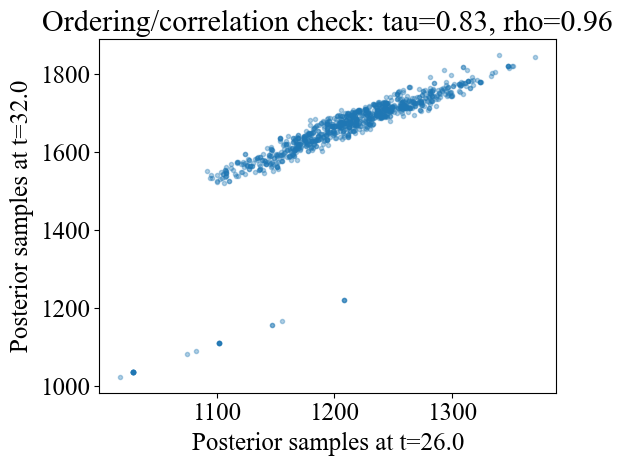


[DIAGNÓSTICO] group=control_resistant, mouse=c1_m2
t_focus ~ 25.00 (idx 14) | width(t_focus) = 124.6
min width em t = 0.00 (idx 0) | min width = 113.5
Kendall tau (t_focus vs t_end) = 0.436 (p=1.7e-94)
Spearman rho (t_focus vs t_end) = 0.592 (p=1.7e-95)
Interpretação: tau/rho próximos de 1 -> pouca reordenação (poucos cruzamentos); tau/rho baixos -> muita reordenação (muitos cruzamentos).


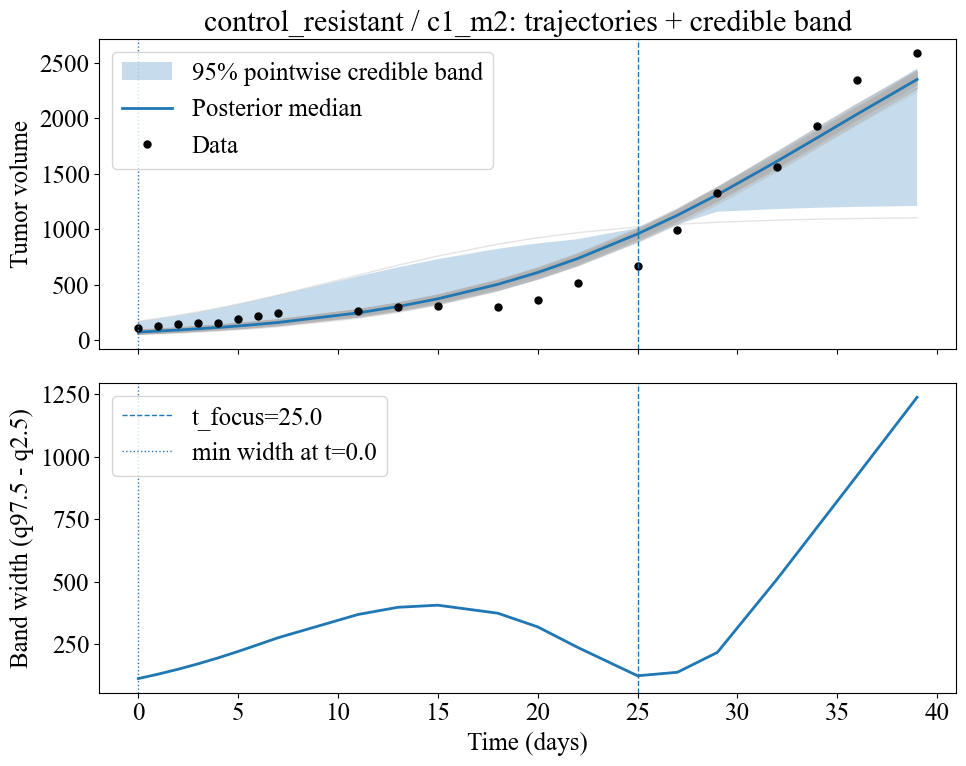

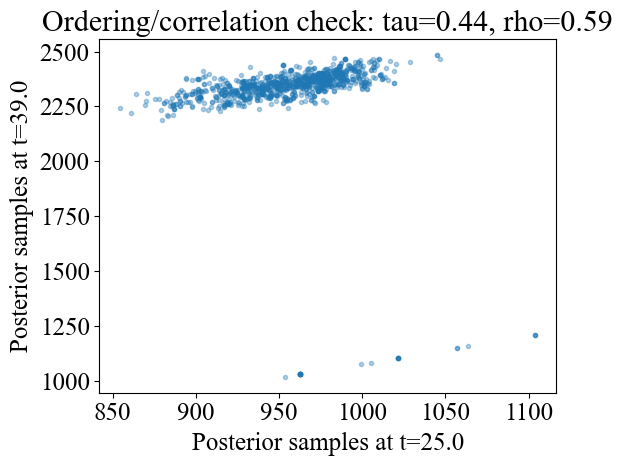

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, spearmanr

def pinch_diagnostics(results, full_data, group, mouse_name,
                      t_focus=25.0, n_plot=80, seed=0):
    """
    results[group][mouse_name] deve ter shape (n_samples, n_times)
    full_data[group] deve conter dicts com 'name' e 'data' (col0=time, col1=volume).
    """
    # --- pega matriz de trajetórias posteriores e dados ---
    mtx = results[group][mouse_name]  # (n_samp, n_times)
    mouse = next(m for m in full_data[group] if m["name"] == mouse_name)
    t = mouse["data"][:, 0]
    y = mouse["data"][:, 1]

    # --- quantis ponto-a-ponto e largura da banda ---
    q_lo, q_med, q_hi = np.percentile(mtx, [2.5, 50, 97.5], axis=0)
    width = q_hi - q_lo

    # índices de interesse
    i_focus = int(np.argmin(np.abs(t - t_focus)))
    i_minw = int(np.argmin(width))

    # --- métricas simples de "cruzamento"/reordenação ---
    # Kendall tau: preservação de ordem entre amostras em dois tempos
    tau_f_end, p_tau = kendalltau(mtx[:, i_focus], mtx[:, -1])
    rho_f_end, p_rho = spearmanr(mtx[:, i_focus], mtx[:, -1])

    print(f"\n[DIAGNOSIS] group={group}, mouse={mouse_name}")
    print(f"t_focus ~ {t[i_focus]:.2f} (idx {i_focus}) | width(t_focus) = {width[i_focus]:.4g}")
    print(f"min width em t = {t[i_minw]:.2f} (idx {i_minw}) | min width = {width[i_minw]:.4g}")
    print(f"Kendall tau (t_focus vs t_end) = {tau_f_end:.3f} (p={p_tau:.2g})")
    print(f"Spearman rho (t_focus vs t_end) = {rho_f_end:.3f} (p={p_rho:.2g})")
    print("Interpretation: tau/rho close to 1 -> little rearrangement (few crossovers);"
          "low tau/rho -> much rearrangement (many crossovers).")

    rng = np.random.default_rng(seed)
    n_samp = mtx.shape[0]
    idx_plot = rng.choice(n_samp, size=min(n_plot, n_samp), replace=False)

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    ax = axes[0]

    ax.plot(t, mtx[idx_plot].T, color="0.7", lw=1, alpha=0.35)

    ax.fill_between(t, q_lo, q_hi, alpha=0.25, label="95% pointwise credible band")
    ax.plot(t, q_med, lw=2, label="Posterior median")

    ax.plot(t, y, "o", color="k", ms=5, label="Data")
    ax.axvline(t[i_focus], ls="--", lw=1)
    ax.axvline(t[i_minw], ls=":", lw=1)

    ax.set_ylabel("Tumor volume")
    ax.legend(loc="best")
    ax.set_title(f"{group} / {mouse_name}: trajectories + credible band")

    ax2 = axes[1]
    ax2.plot(t, width, lw=2)
    ax2.axvline(t[i_focus], ls="--", lw=1, label=f"t_focus={t[i_focus]:.1f}")
    ax2.axvline(t[i_minw], ls=":", lw=1, label=f"min width at t={t[i_minw]:.1f}")
    ax2.set_xlabel("Time (days)")
    ax2.set_ylabel("Band width (q97.5 - q2.5)")
    ax2.legend(loc="best")

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 5))
    plt.plot(mtx[:, i_focus], mtx[:, -1], "o", ms=3, alpha=0.35)
    plt.xlabel(f"Posterior samples at t={t[i_focus]:.1f}")
    plt.ylabel(f"Posterior samples at t={t[-1]:.1f}")
    plt.title(f"Ordering/correlation check: tau={tau_f_end:.2f}, rho={rho_f_end:.2f}")
    plt.tight_layout()
    plt.show()

    return {
        "t_focus": float(t[i_focus]),
        "t_min_width": float(t[i_minw]),
        "width_at_focus": float(width[i_focus]),
        "min_width": float(width[i_minw]),
        "kendall_tau_focus_end": float(tau_f_end),
        "spearman_rho_focus_end": float(rho_f_end),
    }

out_A = pinch_diagnostics(results, full_data, "control_sensitive", "c0_m29", t_focus=25.0, n_plot=80, seed=1)
out_D = pinch_diagnostics(results, full_data, "control_resistant", "c1_m2", t_focus=25.0, n_plot=80, seed=1)


# BIC and BIC weights

In [ ]:
def calculate_n_total(full_data, group):
    n_total = 0
    for mouse_data in full_data[group]:

        n_total += len(mouse_data['data'])
    return n_total

all_models = ['_logV1', '_logV2', '_logV3', '_logV4']

group_ll_total    = {'control_sensitive': {}, 'control_resistant': {}}
group_params_total = {'control_sensitive': {}, 'control_resistant': {}}
group_obs_total   = {'control_sensitive': 0, 'control_resistant': 0}
group_bic         = {'control_sensitive': {}, 'control_resistant': {}}

for model in all_models:
    for group in group_ll_total:
        group_ll_total[group][model] = 0.0
        group_params_total[group][model] = 0
        group_bic[group][model] = np.nan

for group in ['control_sensitive', 'control_resistant']:
    n_total = calculate_n_total(full_data, group)
    group_obs_total[group] = n_total 

    for model in all_models:
        files_location = f'./Output_Calibration/multi_ll_pars_{group}{model}.npz'
        npzfile = np.load(files_location)
        
        max_ll = npzfile['max_ll']
        theta  = npzfile['pars']
        k = len(theta) 
        
        group_ll_total[group][model]    = max_ll
        group_params_total[group][model] = k

        if n_total > 0:
            bic_global = k * np.log(n_total) - 2 * max_ll
        else:
            bic_global = np.nan
        group_bic[group][model] = bic_global

print("% --- BIC ---")
header = "group & " + " & ".join([model.replace('_', '') for model in all_models]) + " \\\\ \\hline"
print(header)

for group in ['control_sensitive', 'control_resistant']:
    row_text = f"{group} "
    for model in all_models:
        bic_global = group_bic[group][model]
        row_text += f"& {bic_global:.2f} "
    print(row_text + "\\\\ \\hline")

print("\n% --- WBIC (BIC weights) ---")
header_wbic = "group & " + " & ".join([model.replace('_', '') for model in all_models]) + " \\\\ \\hline"
print(header_wbic)

for group in ['control_sensitive', 'control_resistant']:
    row_text = f"{group} "

    bics = np.array([group_bic[group][model] for model in all_models], dtype=float)

    mask_valid = ~np.isnan(bics)
    if mask_valid.sum() == 0:

        for _ in all_models:
            row_text += "& nan "
    else:
        bics_valid = bics[mask_valid]
        bic_min = bics_valid.min()
        delta = bics - bic_min

        weights = np.zeros_like(delta, dtype=float)
        weights[mask_valid] = np.exp(-0.5 * delta[mask_valid])
        weights_sum = weights[mask_valid].sum()
        if weights_sum > 0:
            weights[mask_valid] /= weights_sum
        else:

            weights[mask_valid] = 1.0 / mask_valid.sum()

        for w in weights:
            row_text += f"& {w:.3f} "

    print(row_text + "\\\\ \\hline")


% --- BIC ---
group & logV1 & logV2 & logV3 & logV4 \\ \hline
control_sensitive & 3615.35 & 3613.56 & 3625.08 & 3651.23 \\ \hline
control_resistant & 3590.34 & 3588.54 & 3600.06 & 3626.21 \\ \hline

% --- WBIC (BIC weights) ---
group & logV1 & logV2 & logV3 & logV4 \\ \hline
control_sensitive & 0.289 & 0.709 & 0.002 & 0.000 \\ \hline
control_resistant & 0.289 & 0.709 & 0.002 & 0.000 \\ \hline


# All solutions by group for supplementary material


Processando grupo: control_sensitive
Lendo o arquivo de chains: ./Output_Calibration/multi_chain_control_sensitive_logV2.gz

Processando grupo: control_resistant
Lendo o arquivo de chains: ./Output_Calibration/multi_chain_control_resistant_logV2.gz

./Output_Calibration/multi_ll_pars_control_sensitive_logV2.npz - Best Parameters: [8.89429860e-02 3.69671552e+03 1.74715487e+02 1.72673931e+02
 1.73966946e+02 1.66202131e+01 5.33788053e+01 5.89327440e+01
 9.81786082e+01 1.48759082e+02 5.92797761e+01 1.28030864e+02]

./Output_Calibration/multi_ll_pars_control_resistant_logV2.npz - Best Parameters: [1.15631515e-01 3.69671552e+03 6.89643720e+01 6.83394906e+01
 1.28497759e+02 1.01206668e+02 1.11420968e+02 1.28030864e+02]


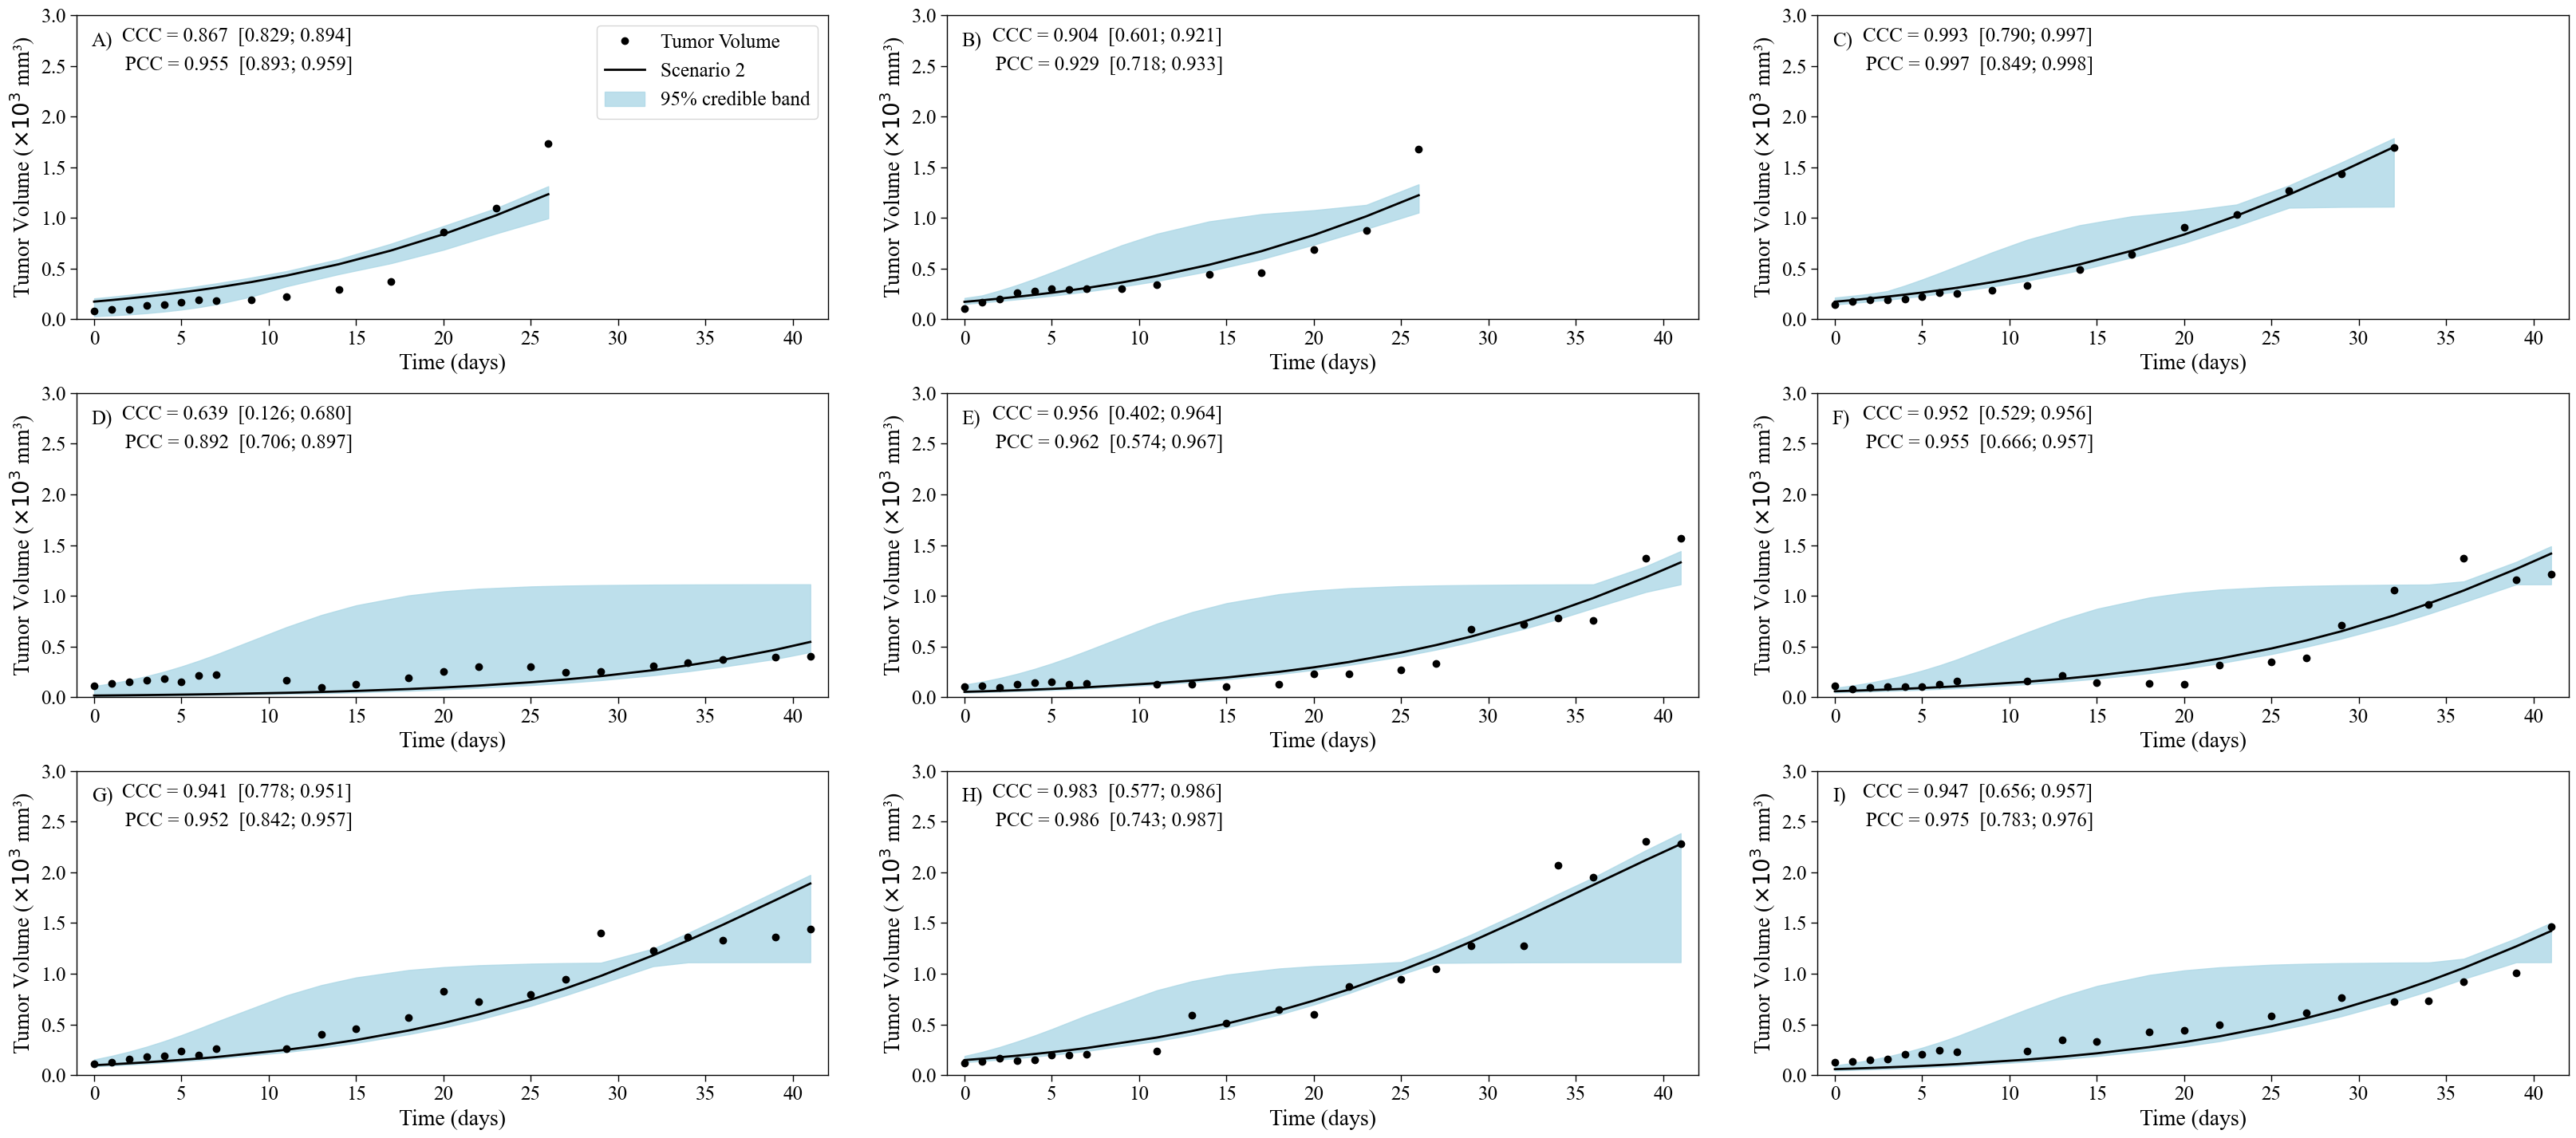

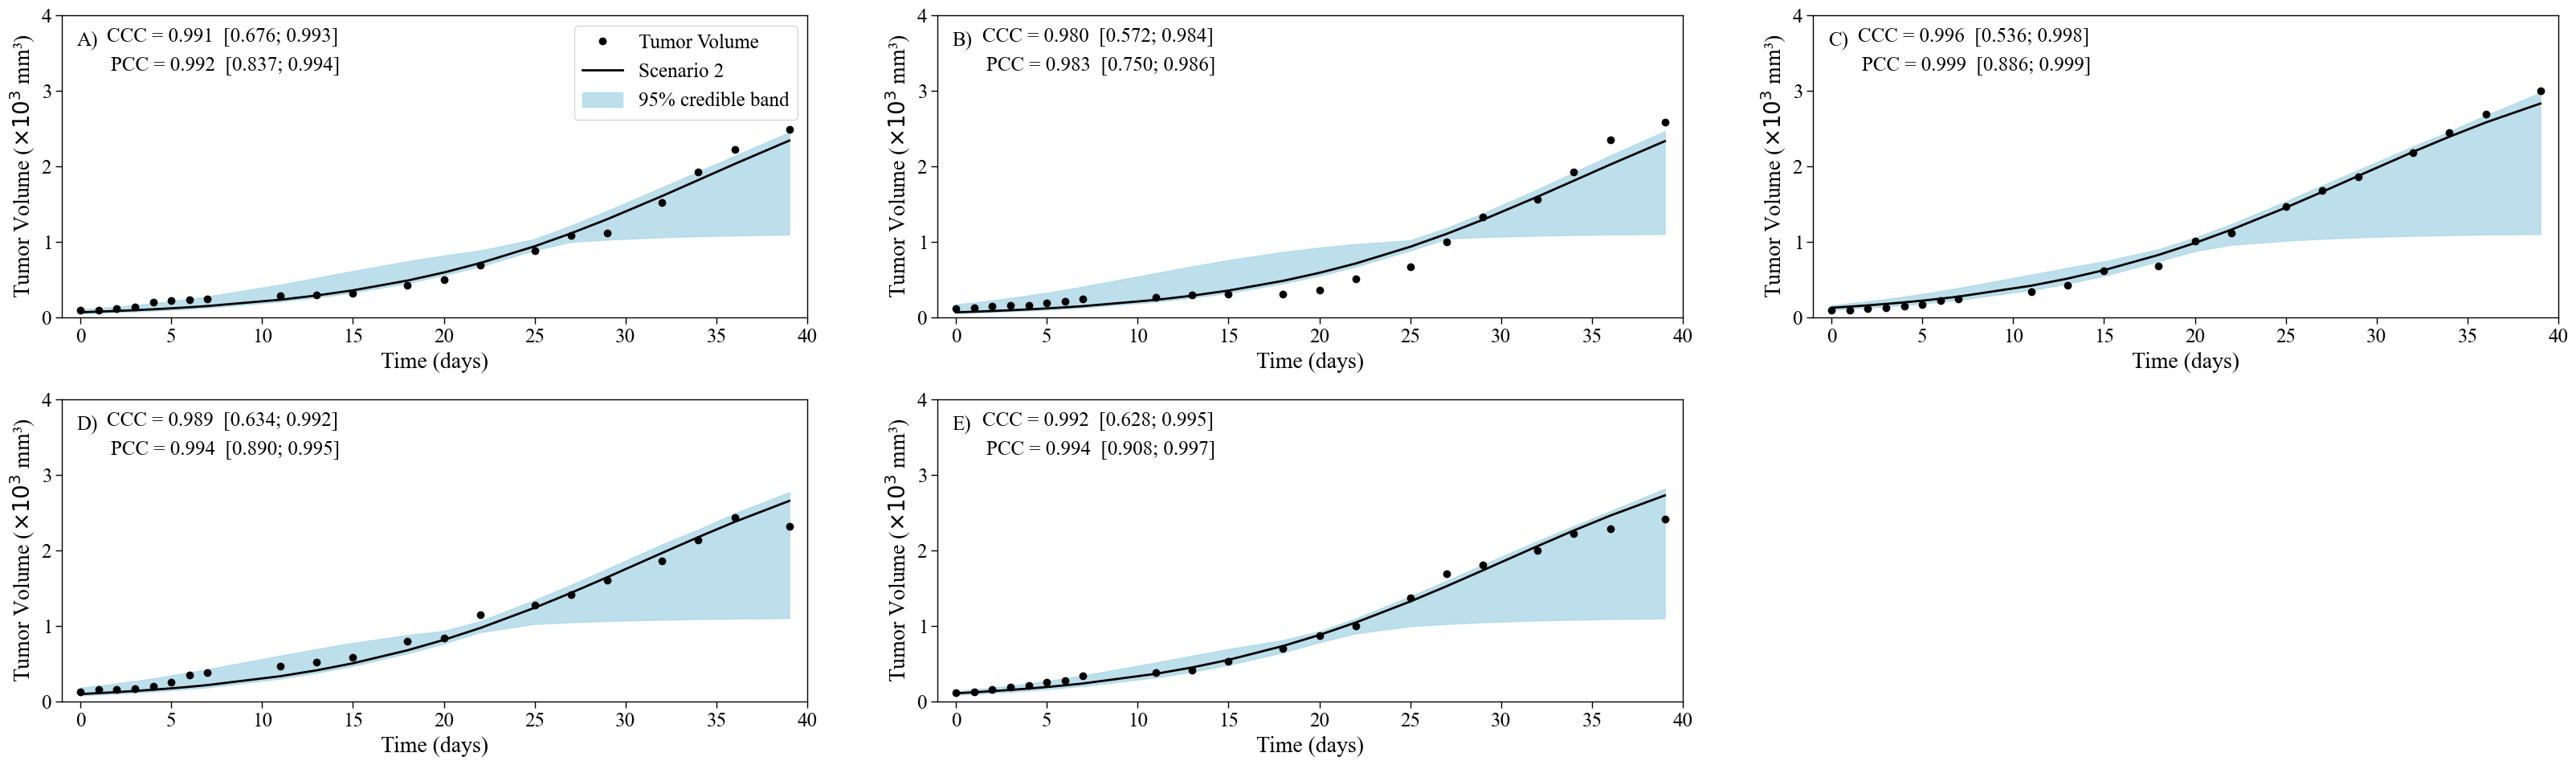

In [ ]:
import matplotlib.gridspec as gridspec 
import matplotlib.lines as mlines
import scipy.stats as stats
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
class ScalarFormatterWithDecimals(ScalarFormatter):
    def _set_format(self):
        self.format = '%.1f'

import os
import pandas as pd
import glob
import math
import emcee
import string
import corner
import numpy as np
from tqdm import tqdm
from numba import jit
import concurrent.futures
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.ticker as mticker
from scipy.integrate import odeint
import pdse_project as pdse
import seaborn as sns
# import scipy.stats as stats
import sys
import random
import scipy.stats

# Find and sort all text files in the ./data directory
data_files = sorted(glob.glob("./data/*.txt"))

# Dictionary to store the parsed data, grouped by data type
full_data = {}

# Loop through each file in the data_files list
for file in data_files:
    # Extract the data type (treatment and cell type) from the file name
    data_type = os.path.basename(file).split('/')[-1].split('_c')[0]
    
    # Extract the mouse name (cohort identifier) from the file name
    mouse_name = 'c' + file.split('/')[-1].split('_c')[-1].split('_t')[0]
    
    # Extract the treatment days from the file name (as integers)
    t_days = np.array([int(t) for t in file.split('/')[-1].split('_c')[-1].split('.txt')[0].split('_t')[1:]])
    
    # Load the measurement data from the file (time, tumor volume)
    data = np.loadtxt(file)
    
    # Extract the specific treatment from the data type (e.g., radiation or control)
    treatment = os.path.basename(data_type).split('_')[0]
    
    # If this data type hasn't been seen before, create a new list in full_data
    if data_type not in full_data:
        full_data[data_type] = []
    
    # Append the mouse's data (including name, tumor measurements, treatment, and treatment days) to the appropriate group
    full_data[data_type].append({
        'name': mouse_name,
        'data': data,
        'treatment': treatment,
        'treatment_days': t_days
    })


def ccc(x, y):
    x, y = np.asarray(x), np.asarray(y)
    sxy = np.sum((x - x.mean()) * (y - y.mean())) / x.size
    return 2*sxy / (np.var(x) + np.var(y) + (x.mean()-y.mean())**2)

def pcc(x, y):
    x, y = np.asarray(x), np.asarray(y)
    sxy = np.sum((x - x.mean()) * (y - y.mean())) / x.size
    return sxy / (np.std(x) * np.std(y))

def summarize_posterior(arr, alpha=0.05):
    arr = np.asarray(arr, dtype=float)
    med = np.median(arr)
    lo, hi = np.percentile(arr, [100*alpha/2, 100*(1-alpha/2)])
    return med, lo, hi


@jit(nopython=True)
def model_log(y, t, growth_rate, carrying_capacity):
    tumor = y
    tumorVolume = growth_rate * tumor * (1 - tumor/carrying_capacity)
    return tumorVolume


def solve_model(model_extension, time_array, parameters, initial_condition, type_sol = 'data'):
    model_name = 'model' + model_extension
    model_func = globals()[model_name]  # Get the function object by its name

    if type_sol == 'smooth':
        bgn_p = round(time_array[0],1)
        end_p = round(time_array[-1],1)
        time_array = np.linspace(bgn_p,end_p, int((end_p-bgn_p)/0.1)+1)
        sol = odeint(model_func, t = time_array, y0 = [initial_condition], args = parameters, mxstep=2000)
        return np.column_stack((time_array, sol))
    else:
        return odeint(model_func, t = time_array, y0 = [initial_condition], args = parameters, mxstep=2000)
    
def find_max_time_per_group(full_data):
    max_times = {}

    for group, mice_data in full_data.items():
        max_time = 0

        for mouse in mice_data:
            time_data = mouse['data'][:, 0]  
            max_time_mouse = max(time_data)  

            if max_time_mouse > max_time:
                max_time = max_time_mouse

        max_times[group] = max_time

    return max_times

def analyze_chains_for_groups(chain_files_sensitive, chain_files_resistant, full_data, seed=42):
    """
    Function to analyze the chains of two groups (control_sensitive and control_resistant), solve the model for 50 randomly selected samples, and store the results.
Parameters:

    Parameters:
        chain_files_sensitive (list): List of chain files for the ‘control_sensitive’ group.
        chain_files_resistant (list): List of chain files for the ‘control_resistant’ group.
        full_data (dict): Complete data grouped by type.

    Returns:
        dict: Dictionary containing arrays of model solutions for each group.
    """
    results = {}

    for group, chain_files in zip(['control_sensitive', 'control_resistant'], 
                                  [chain_files_sensitive, chain_files_resistant]):
        print(f"\nProcessando grupo: {group}")
        
        group_results = {}  

        model_extension = "_log"  

        ndim = len(full_data[group])
        
        for chain_file in chain_files:
            print(f"Lendo o arquivo de chains: {chain_file}")

            chain_data = np.loadtxt(chain_file)

            random.seed(seed)
            selected_indices = random.sample(range(len(chain_data)), 200)
            selected_samples = chain_data[selected_indices, :]

            for idx, mouse_data in enumerate(full_data[group]):
                mouse_name = mouse_data['name']
                data = mouse_data['data']

                num_time_points = len(data[:, 0])
                solution_matrix = np.zeros((len(selected_samples), num_time_points))

                for sample_idx, theta in enumerate(selected_samples):
                    parameters = tuple(theta[:-(ndim+1)])
                    initial_condition = theta[-(ndim+1) + idx]

                    solution = solve_model(model_extension, data[:, 0], parameters, initial_condition, "smooth")


                    mask = np.isin(solution[:, 0], data[:, 0])
                    selected_solution = solution[mask]

                    matched_solution_volumes = selected_solution[:, 1]


                    solution_matrix[sample_idx, :] = matched_solution_volumes


                group_results[mouse_name] = solution_matrix

        results[group] = group_results

    return results

chain_files_sensitive = [
    './Output_Calibration/multi_chain_control_sensitive_logV2.gz',
]

chain_files_resistant = [
    './Output_Calibration/multi_chain_control_resistant_logV2.gz'
]

results = analyze_chains_for_groups(chain_files_sensitive, chain_files_resistant, full_data)


def summarize_solutions_with_ci(results):

    summarized = {}
    for grp, mice in results.items():
        summarized[grp] = {}
        for mouse, mtx in mice.items(): 
            mean = mtx.mean(axis=0)
            p_lo, p_hi = np.percentile(mtx, [2.5, 97.5], axis=0)
            summarized[grp][mouse] = {
                'mean': mean,
                'ci_positive': p_hi,
                'ci_negative': p_lo
            }
    return summarized

summarized_results1 = summarize_solutions_with_ci(results)

def configure_plot_settings(fontsize):
    plt.rcParams['font.size'] = fontsize
    formatter = mticker.ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3, 2))
    return formatter


def finalize_plot(fig, axes, nScenarios, nCols, nRows, full_exp, full_model, save, show, figure_name, formatter):
    final_exp = np.concatenate(full_exp, axis=0) if full_exp else np.array([])
    final_model = np.concatenate(full_model, axis=0) if full_model else np.array([])

    if final_exp.size == 0 or final_model.size == 0:
        print("Error: One of the final arrays is empty.")
        return

    rounded_max = math.ceil(np.max(np.concatenate([final_exp, final_model])) / 1000) * 1000
    for ax in axes[:nScenarios]:
        ax.set_ylim((0, rounded_max))
        ax.yaxis.set_major_formatter(formatter)
    for i in range(nScenarios, nRows * nCols):
        fig.delaxes(axes[i])
    if save:
        plt.savefig(figure_name + '.png', dpi=300, bbox_inches='tight', pad_inches=0.02)
    if show:
        plt.show()
    else:
        plt.close()

def posterior_corr_from_chain(chain_path, model_extension, full_data, group,
                                n_samp=1000, seed=42):
    if not os.path.exists(chain_path):
        print(f"[ERRO] Chain não encontrada: {chain_path}")
        return None
    chain = np.loadtxt(chain_path)
    if chain.ndim == 1:
        chain = chain.reshape(1, -1)
    ndim = len(full_data[group])
    n_samp = min(n_samp, chain.shape[0])
    rng = np.random.default_rng(seed)
    idx = rng.choice(chain.shape[0], size=n_samp, replace=False)
    thetas = chain[idx, :]

    ccc_samples, pcc_samples = [], []
    for theta in thetas:
        params = tuple(theta[:-(ndim+1)])
        ics = theta[-(ndim+1):-1]
        full_model, full_exp = [], []
        for i, mouse in enumerate(full_data[group]):
            t = mouse['data'][:, 0]; y = mouse['data'][:, 1]
            sol = solve_model(model_extension, t, params, ics[i], 'data')
            if sol.ndim == 2 and sol.shape[1] == 1:
                sol = sol[:, 0]
            full_model.append(sol); full_exp.append(y)
        model_concat = np.concatenate(full_model)
        exp_concat = np.concatenate(full_exp)
        ccc_samples.append(float(np.clip(ccc(model_concat, exp_concat), -1, 1)))
        pcc_samples.append(float(np.clip(pcc(model_concat, exp_concat), -1, 1)))

    ccc_med, ccc_lo, ccc_hi = summarize_posterior(ccc_samples)
    pcc_med, pcc_lo, pcc_hi = summarize_posterior(pcc_samples)
    return {"ccc_summary": (ccc_med, ccc_lo, ccc_hi),
            "pcc_summary": (pcc_med, pcc_lo, pcc_hi)}

res_cs = posterior_corr_from_chain(
    './Output_Calibration/multi_chain_control_sensitive_logV2.gz',
    '_log', full_data, 'control_sensitive', n_samp=1000, seed=42)

res_cr = posterior_corr_from_chain(
    './Output_Calibration/multi_chain_control_resistant_logV2.gz',
    '_log', full_data, 'control_resistant', n_samp=1000, seed=42)

# extração das medianas e IC
ccc_med_cs, ccc_lo_cs, ccc_hi_cs = res_cs["ccc_summary"]
pcc_med_cs, pcc_lo_cs, pcc_hi_cs = res_cs["pcc_summary"]
ccc_med_cr, ccc_lo_cr, ccc_hi_cr = res_cr["ccc_summary"]
pcc_med_cr, pcc_lo_cr, pcc_hi_cr = res_cr["pcc_summary"]


def posterior_corr_per_mouse(chain_path, model_extension, full_data, group,
                             n_samp=1000, seed=42):
    if not os.path.exists(chain_path):
        print(f"[ERRO] Chain não encontrada: {chain_path}")
        return None, None

    chain = np.loadtxt(chain_path)
    if chain.ndim == 1:
        chain = chain.reshape(1, -1)

    ndim = len(full_data[group])
    n_samp = min(n_samp, chain.shape[0])

    rng = np.random.default_rng(seed)
    idx = rng.choice(chain.shape[0], size=n_samp, replace=False)
    thetas = chain[idx, :]

    mouse_names = [m['name'] for m in full_data[group]]
    ccc_samples = {name: [] for name in mouse_names}
    pcc_samples = {name: [] for name in mouse_names}

    for theta in thetas:
        params = tuple(theta[:-(ndim+1)])
        ics    = theta[-(ndim+1):-1] 

        for i, mouse in enumerate(full_data[group]):
            name = mouse['name']
            t = mouse['data'][:, 0]
            y = mouse['data'][:, 1]

            sol = solve_model(model_extension, t, params, ics[i], 'data')
            if sol.ndim == 2 and sol.shape[1] == 1:
                sol = sol[:, 0]

            ccc_val = float(np.clip(ccc(sol, y), -1, 1))
            pcc_val = float(np.clip(pcc(sol, y), -1, 1))

            ccc_samples[name].append(ccc_val)
            pcc_samples[name].append(pcc_val)

    ccc_res = {name: summarize_posterior(vals) for name, vals in ccc_samples.items()}
    pcc_res = {name: summarize_posterior(vals) for name, vals in pcc_samples.items()}

    return ccc_res, pcc_res

ccc_cs, pcc_cs = posterior_corr_per_mouse(
    './Output_Calibration/multi_chain_control_sensitive_logV2.gz',
    '_log', full_data, 'control_sensitive', n_samp=1000, seed=42)

ccc_cr, pcc_cr = posterior_corr_per_mouse(
    './Output_Calibration/multi_chain_control_resistant_logV2.gz',
    '_log', full_data, 'control_resistant', n_samp=1000, seed=42)

post_corr = {
    **{f"s_{name}": ccc_cs[name] for name in ccc_cs.keys()},
    **{f"r_{name}": ccc_cr[name] for name in ccc_cr.keys()}
}
post_pcc = {
    **{f"s_{name}": pcc_cs[name] for name in pcc_cs.keys()},
    **{f"r_{name}": pcc_cr[name] for name in pcc_cr.keys()}
}
    
def plot_maxll_solution_with_deviation_melhor_pior_juntos(
    files_locations_sensitive, 
    files_locations_resistant, 
    summarized_results, 
    full_data, 
    show=True, 
    save=True, 
    fontsize='18', 
    figure_name='maxll_figure'):

    if not show and not save:
        return 

    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif']  = ['Times New Roman']
    formatter = configure_plot_settings(fontsize)
    plt.rcParams['font.size'] = fontsize

    def get_suffix(file_location):
        return file_location.split('_')[-1].split('.')[0]

    manual_labels = {
        'logV1': "$r_s$, $r_r$, $K_s$, $K_r$",
        'logV2': "Scenario 2",
        'logV3': "$r$, $K_s$ and $K_r$",
        'logV4': "$r$ and $K$"
    }

    def load_parameters(files):
        all_theta, all_suffix = [], []
        for file_location in files:
            npzfile = np.load(file_location)
            best_pars = npzfile['pars']
            all_theta.append(best_pars)
            all_suffix.append(get_suffix(file_location))
            print(f"\n{file_location} - Best Parameters:", best_pars)
        return all_theta, all_suffix

    all_theta_sensitive, all_suffix_sensitive = load_parameters(files_locations_sensitive or [])
    all_theta_resistant, all_suffix_resistant = load_parameters(files_locations_resistant or [])

    max_times = find_max_time_per_group(full_data)
    linestyles = ['solid', 'dashed', 'dotted', 'dashdot']
    colors = ['black', 'red', 'green', 'blue', 'cyan']

    def plot_scatter_ax(ax, final_exp, final_model, formatter,
                        ccc_val=None, ccc_ic=None, pcc_val=None, pcc_ic=None):
        all_cccs = []
        for i in range(len(final_exp)):
            ccc_value = pdse.ccc(final_model[i], final_exp[i])
            all_cccs.append(ccc_value)
            ax.plot(final_exp[i], final_model[i], 'o', color='blue')

        ax.set_xlabel(r'Data - Tumor Volume ($\times 10^3$ mm³)', fontsize=20)
        ax.set_ylabel(r'Model - Tumor Volume ($\times 10^3$ mm³)', fontsize=20)

        line = mlines.Line2D([0, 1], [0, 1], color='black', linestyle='dashed')
        line.set_transform(ax.transAxes)
        ax.add_line(line)

        final_exp = np.concatenate(final_exp)
        final_model = np.concatenate(final_model)
        max_value = math.ceil(max(max(final_exp), max(final_model)) / 1000) * 1000
        ticks = np.linspace(0, max_value, num=int(max_value/1000)+1)

        ax.set_xlim((0, max_value))
        ax.set_ylim((0, max_value))
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        
        formatter = ScalarFormatterWithDecimals(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 2))

        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        ax.ticklabel_format(axis='y', style='scientific', scilimits=(-3, 2), useOffset=False)
        ax.grid(False)

        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1.0)

        ax.tick_params(axis='both', which='major', length=6, width=1, direction='out', color='black', bottom=True, left=True)
        ax.minorticks_off()

        if ccc_val is not None and ccc_ic is not None and pcc_val is not None and pcc_ic is not None:
            # posterior medians + CI
            ax.text(0.06, 0.94,
                    f'CCC = {ccc_val:.3f}  [{ccc_ic[0]:.3f}; {ccc_ic[1]:.3f}]',
                    transform=ax.transAxes, fontsize=18, verticalalignment='top')
            ax.text(0.065, 0.875,
                    f'PCC = {pcc_val:.3f}  [{pcc_ic[0]:.3f}; {pcc_ic[1]:.3f}]',
                    transform=ax.transAxes, fontsize=18, verticalalignment='top')
        else:
            pccT = pdse.pcc(final_model, final_exp)
            cccT = pdse.ccc(final_model, final_exp)
            mapeT = pdse.mape(final_model, final_exp)
            ax.text(0.06, 0.82,
                    f'CCC/PCC/MAPE = {cccT:.2f}/{pccT:.2f}/{mapeT:.2f}%',
                    transform=ax.transAxes, fontsize=18)

    def make_figure_for_group(group_name,
                              all_theta,
                              all_suffix,
                              summarized_results,
                              full_data,
                              ccc_group_summary,
                              pcc_group_summary,
                              figure_name_base):

        if len(all_theta) == 0:
            print(f"[AVISO] Não há parâmetros para o grupo {group_name}.")
            return

        if group_name not in full_data:
            print(f"[AVISO] Grupo {group_name} não encontrado em full_data.")
            return

        theta = all_theta[0]
        suffix = all_suffix[0]
        label_model = manual_labels.get(suffix, f'Model {suffix}')

        mice = full_data[group_name]
        n_mice_total = len(mice)

        width_per_panel = 22 / 2.0  
        height_per_panel = 15 / 3.0  

        if group_name == 'control_sensitive':

            nCols, nRows = 3, 3
        else:  

            nCols, nRows = 3, 2

        fig, axes = plt.subplots(
            nRows,
            nCols,
            figsize=(width_per_panel * nCols, height_per_panel * nRows)
        )
        axes = axes.flatten()
        ts_axes = axes 

        max_ts_panels = len(ts_axes)
        n_mice_to_plot = min(n_mice_total, max_ts_panels)

        full_exp_group, full_model_group = [], []

        if group_name == 'control_sensitive':
            ccc_dict = ccc_cs
            pcc_dict = pcc_cs
        else:
            ccc_dict = ccc_cr
            pcc_dict = pcc_cr

        ndim = len(mice)

        for idx in range(n_mice_to_plot):
            mouse_data = mice[idx]
            ax = ts_axes[idx]

            mouse_name = mouse_data['name']
            data = mouse_data['data']
            t = data[:, 0]
            y = data[:, 1]

            params = tuple(theta[:-(ndim+1)])
            ic = theta[-(ndim+1) + idx]
            sol = solve_model("_log", t, params, ic, "smooth")
            mask = np.isin(sol[:, 0], t)
            sol_times = sol[mask, 0]
            sol_volumes = sol[mask, 1]

            ax.plot(t, y, 'o', color='black', markersize=6, label='Tumor Volume')

            ax.plot(
                sol_times,
                sol_volumes,
                color=colors[0],
                linestyle=linestyles[0],
                linewidth=2,
                label=label_model
            )


            if group_name in summarized_results and mouse_name in summarized_results[group_name]:
                res = summarized_results[group_name][mouse_name]
                ax.fill_between(
                    t,
                    res['ci_positive'],
                    res['ci_negative'],
                    color='lightblue',
                    alpha=0.8,
                    label=r'95% credible band'
                )

            if mouse_name in ccc_dict:
                ccc_med, ccc_lo, ccc_hi = ccc_dict[mouse_name]
                pcc_med, pcc_lo, pcc_hi = pcc_dict[mouse_name]

                ax.text(
                    0.06, 0.96,
                    f'CCC = {ccc_med:.3f}  [{ccc_lo:.3f}; {ccc_hi:.3f}]',
                    transform=ax.transAxes,
                    fontsize=18,
                    verticalalignment='top'
                )

                ax.text(
                    0.065, 0.865,
                    f'PCC = {pcc_med:.3f}  [{pcc_lo:.3f}; {pcc_hi:.3f}]',
                    transform=ax.transAxes,
                    fontsize=18,
                    verticalalignment='top'
                )


            ax.set_xlabel('Time (days)', fontsize=20)
            ax.set_ylabel(r'Tumor Volume ($\times10^3$ mm³)', fontsize=20)
            ax.set_xlim((-1, max_times[group_name] + 1))
            ax.ticklabel_format(axis='y', style='scientific',
                                scilimits=(-3, 2), useOffset=False)
            ax.yaxis.get_offset_text().set_visible(False)

            fmt_y = ScalarFormatterWithDecimals(useMathText=True)
            fmt_y.set_scientific(True)
            fmt_y.set_powerlimits((-3, 2))
            ax.yaxis.set_major_formatter(fmt_y)
            ax.yaxis.get_major_formatter().set_scientific(False)
            ax.yaxis.offsetText.set_visible(False)
            ax.grid(False)

            full_model_group.append(sol_volumes)
            full_exp_group.append(y)

            if idx == 0:
                ax.legend(loc=1, fontsize=18)

        for idx in range(n_mice_to_plot):
            ax = ts_axes[idx]
            ax.text(
                0.02, 0.9,
                f'{string.ascii_uppercase[idx]})',
                transform=ax.transAxes,
                fontsize=18
            )
            for spine in ax.spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1.0)
            ax.tick_params(axis='both', which='major',
                           length=6, width=1, direction='out',
                           color='black', bottom=True, left=True)
            ax.minorticks_off()

            ax.ticklabel_format(axis='y', style='scientific',
                                scilimits=(-3, 2), useOffset=False)
            ax.yaxis.offsetText.set_visible(False)
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

            ax.ticklabel_format(axis='x', style='scientific',
                                scilimits=(-3, 2), useOffset=False)
            ax.xaxis.get_offset_text().set_visible(False)

        fig.tight_layout()
        fig.subplots_adjust(top=0.95)

        if full_exp_group and full_model_group:
            finalize_plot(
                fig,
                axes,
                nScenarios=n_mice_to_plot,
                nCols=nCols,
                nRows=nRows,
                full_exp=full_exp_group,
                full_model=full_model_group,
                save=save,
                show=show,
                figure_name=figure_name_base,
                formatter=formatter
            )
        else:
            if save:
                fig.savefig(
                    figure_name_base + '.png',
                    dpi=300, bbox_inches='tight', pad_inches=0.02
                )
            if show:
                plt.show()
            else:
                plt.close(fig)

    ccc_group_cs = (ccc_med_cs, ccc_lo_cs, ccc_hi_cs)
    pcc_group_cs = (pcc_med_cs, pcc_lo_cs, pcc_hi_cs)
    ccc_group_cr = (ccc_med_cr, ccc_lo_cr, ccc_hi_cr)
    pcc_group_cr = (pcc_med_cr, pcc_lo_cr, pcc_hi_cr)

    make_figure_for_group(
        group_name='control_sensitive',
        all_theta=all_theta_sensitive,
        all_suffix=all_suffix_sensitive,
        summarized_results=summarized_results,
        full_data=full_data,
        ccc_group_summary=ccc_group_cs,
        pcc_group_summary=pcc_group_cs,
        figure_name_base=figure_name + '_sensitive'
    )

    make_figure_for_group(
        group_name='control_resistant',
        all_theta=all_theta_resistant,
        all_suffix=all_suffix_resistant,
        summarized_results=summarized_results,
        full_data=full_data,
        ccc_group_summary=ccc_group_cr,
        pcc_group_summary=pcc_group_cr,
        figure_name_base=figure_name + '_resistant'
    )

    return

plot_maxll_solution_with_deviation_melhor_pior_juntos(
    files_locations_sensitive=[
        './Output_Calibration/multi_ll_pars_control_sensitive_logV2.npz'
    ],
    files_locations_resistant=[
        './Output_Calibration/multi_ll_pars_control_resistant_logV2.npz'
    ],
    summarized_results=summarized_results1, 
    full_data=full_data,                     
    show=True,
    save=True,
    figure_name='fig5_IC_bayesian' 
)

